In [1]:
from surgeon_recording.reader import Reader
from surgeon_recording.functions_metrics import F_metrics

from os.path import join
import csv
import pandas as pd
import numpy as np
from tabulate import tabulate
import scipy.interpolate as inter
from pyquaternion import Quaternion
from numpy import linalg as LA
import plotly.graph_objects as go
import os
import scipy.ndimage
import scipy.signal
import matplotlib.pyplot as plt
import matplotlib
from plotly.subplots import make_subplots
from plotly import subplots
import matplotlib.lines
from scipy import integrate
import math 

reader = Reader()
f_metrics = F_metrics()

## READ DATA

In [2]:
path_to_data_folder = '/home/anaelle/git/surgeon_recording/data_paper'                 #lasa computer

subject_list_tot = ['S1','S2','S3','S4','S5','S6','S7','S8','S9','S10','S11','S12']
subject_list = ['S2','S3','S4','S5','S6','S7','S8','S9','S10','S11','S12']

segment_list = ['500','510','530','540','541','560']

sensors = ['optitrack']


tools_tweezer = ['tweezer_x', 'tweezer_y', 'tweezer_z']
tools_scissors = ['scissors_x', 'scissors_y', 'scissors_z'] 
tools_verif_holder = ['needle_holder2_x', 'needle_holder2_y', 'needle_holder2_z']


data_segments = {}
mean_segments = {}

run_list = {}
headers = {}
file_list = {}


# List of run we take for analysis, for each subject
run_list = {}
for subject in subject_list:
    run_list[subject] = {}

run_list['S1'] = ['R1','R2','R3'] #ONLY FOR TIME not optitrack data
run_list['S2'] = ['R1','R3','R4']
run_list['S3'] = ['R2','R3','R4']
run_list['S4'] = ['R1','R3','R4']
run_list['S5'] = ['R3','R4','R5']
run_list['S6'] = ['R1','R3','R5']
run_list['S7'] = ['R1','R3','R4']
run_list['S8'] = ['R1','R3','R4']
run_list['S9'] = ['R2','R3','R5']
run_list['S10'] = ['R1','R2','R4']
run_list['S11'] = ['R1','R3','R4']
run_list['S12'] = ['R1','R2','R3']


# Create structures
for subject in subject_list_tot:
    data_segments[subject] = {}
    mean_segments[subject]= {}
    file_list[subject] = {}
        
    for segment in segment_list:
        data_segments[subject][segment]= {}
        file_list[subject][segment] = {}
        mean_segments[subject][segment]= {}
                    
        for run in run_list[subject]:
            data_segments[subject][segment][run] = {}
            mean_segments[subject][segment][run]= {}
            file_list[subject][segment][run] = {}

            for sensor in sensors:
                data_segments[subject][segment][run][sensor]= {}
                mean_segments[subject][segment][run][sensor]= []
                file_list[subject][segment][run][sensor] = []


for sensor in sensors:
    headers[sensor] = []
                
for subject in subject_list_tot:   
        for sensor in sensors:
            for segment in segment_list:
                for run in run_list[subject]:
                    data_folder = join('..', 'data_paper','OPTITRACK', subject, run )
                    file_list[subject][segment][run][sensor] = join(data_folder, 'segment_nb_' + segment + '_' + sensor +'.csv')

                    file = open(file_list[subject][segment][run][sensor])
                    reader = csv.DictReader(file)
                    headers[sensor] = reader.fieldnames

                    tools = headers[sensor][3:-1]

                    data = pd.read_csv(file_list[subject][segment][run][sensor])

                    for tool in tools:
                        data_segments[subject][segment][run][sensor][tool]= data[tool]
                        data_segments[subject][segment][run][sensor]['rel_time'] = data['relative_time']              
                    

                            

# DATA OPTITRACK

## REVIEW DATA

### Remove 0 values (loss of tracking)

In [3]:

segment_list_optitrack = ['500','510','530','540','541']
segment_new_optitrack = ['2','3','4','5','6']


tools_position = ['tweezer_x', 'tweezer_y', 'tweezer_z', 'needle_holder2_x', 'needle_holder2_y', 'needle_holder2_z']
tools_quaternions = ['tweezer_qx', 'tweezer_qy', 'tweezer_qz', 'tweezer_qw', 'needle_holder2_qx', 'needle_holder2_qy', 'needle_holder2_qz', 'needle_holder2_qw']

#tools = ['tweezer_x', 'tweezer_y', 'tweezer_z', 'tweezer_qx', 'tweezer_qy', 'tweezer_qz', 'tweezer_qw', 'scissors_x', 'scissors_y', 'scissors_z', 'scissors_qx', 'scissors_qy', 'scissors_qz', 'scissors_qw', 'needle_holder2_x', 'needle_holder2_y', 'needle_holder2_z', 'needle_holder2_qx', 'needle_holder2_qy', 'needle_holder2_qz', 'needle_holder2_qw']
tools = ['tweezer_x', 'tweezer_y', 'tweezer_z', 'tweezer_qx', 'tweezer_qy', 'tweezer_qz', 'tweezer_qw', 'needle_holder2_x', 'needle_holder2_y', 'needle_holder2_z', 'needle_holder2_qx', 'needle_holder2_qy', 'needle_holder2_qz', 'needle_holder2_qw']


sensor = 'optitrack'
optitrack_segment_subject = {}
optitrack_non_zero= {}
optitrack_non_zero_time = {}
for subject in subject_list:   
    optitrack_segment_subject[subject] = {}
    optitrack_non_zero[subject]= {}
    optitrack_non_zero_time[subject] = {}
    for segment in segment_list:
        optitrack_segment_subject[subject][segment] = {}
        optitrack_non_zero[subject][segment]= {}
        optitrack_non_zero_time[subject][segment] = {}
        for run in run_list[subject]:
            optitrack_segment_subject[subject][segment][run] = {}
            optitrack_non_zero[subject][segment][run]= {}
            optitrack_non_zero_time[subject][segment][run] = {}
            for tool in tools:  
                optitrack_segment_subject[subject][segment][run][tool]=[]
                optitrack_non_zero[subject][segment][run][tool] = []
                optitrack_non_zero_time[subject][segment][run] [tool] = []


#remove 0 values from loss of tracking FOR computations BUT should use vectors with the zeroes to keep correspondance of time with data
for subject in subject_list:   
    for segment in segment_list:
        for run in run_list[subject]:
            for tool in tools:
                time_current = data_segments[subject][segment][run][sensor]['rel_time']        
                data_current = data_segments[subject][segment][run][sensor][tool]
                
                optitrack_segment_subject[subject][segment][run][tool] = data_current
                optitrack_non_zero[subject][segment][run][tool] = data_current[data_current != 0]
                optitrack_non_zero_time[subject][segment][run][tool] = time_current[data_current != 0]



### Interpolation data top

In [4]:
Interpole = {}
time_vector_interp = {}
interpolated_data = {}
for subject in subject_list:   
    Interpole[subject] = {}
    time_vector_interp[subject]= {}
    interpolated_data[subject] = {}
    for segment in segment_list:
        Interpole[subject][segment] = {}
        time_vector_interp[subject][segment]= {}
        interpolated_data[subject][segment] = {}
        
        for run in run_list[subject]:
            Interpole[subject][segment][run] = {}
            time_vector_interp[subject][segment][run]= {}
            interpolated_data[subject][segment][run] = {}
            for tool in tools:
                Interpole[subject][segment][run][tool] = {}
                time_vector_interp[subject][segment][run][tool]= {}
                interpolated_data[subject][segment][run][tool] = {}


for subject in subject_list:   
    for segment in segment_list:
        for run in run_list[subject]:
            for tool in tools:

                data = np.array(optitrack_non_zero[subject][segment][run][tool])
                time = np.array(optitrack_non_zero_time[subject][segment][run][tool])
                Interpole[subject][segment][run][tool] = inter.interp1d(time, data )
                time_step = 1/120
                time_vector_interp[subject][segment][run][tool] = np.arange(time.min(),time.max()-time_step,time_step )
                interpolated_data[subject][segment][run][tool] = Interpole[subject][segment][run][tool](time_vector_interp[subject][segment][run][tool])
      

### Transformation to have tip position

In [5]:
# hardcoded tool and tooltip rotation and position in form [qw,qx,qy,qz,tx,ty,tz,1]
#  Quaternion((w, x, y, z)) function: Creates a unit quaternion 1 + 0i + 0j + 0k
# approximation for the 1st set of recorded data (not exact as fell several times + position measured afterwards, the marker was not placed exactly at same location)

tools_name = ["tweezer", "needle_holder2"]
tools_transf = {
    "tweezer": {
        "marker_tip": [-0.14002110139417,0.011598759188847,0.914789185044361,-0.378701883396705,0.203922977186312,0.225921215462611,0.337081560202788,1],     # the one from the fixed marker for tip measurement
        "tip":  [-0.659606319391634,0.047673735107731,-0.082923699619772,-0.520023288973384,0.173957278833967,0.147784077313054,0.464396291508238,1]    # marker to rpz tip
        
    },

    "needle_holder2":  {
        "marker_tip": [-0.921827204331451,0.195545852165725,0.143764196798494,-0.302187299435028,0.181443717514124,0.300805392655367,0.335198482109228,1],
        "tip":  [-0.864763969868174,-0.013123148775895,-0.07854127306968,-0.49579974858757,0.170293133709981,0.248165722222222,0.464240151600753,1]

    }       
}


for tool in tools_name:    
    marker_tip_quaternion = Quaternion(tools_transf[tool]["marker_tip"][:4])  #Return homogeneous rotation matrix from quaternion. = on calcule la matrice de rotation qui correspond aux quaternions du tool (chiffres en haut) #ATTENTION: normalise le quaternion a 1 donc pas exactemetn meme valeurs
    T_marker_tip_fixed = marker_tip_quaternion.transformation_matrix         # deja en 4*4 matrix
    
    marker_tip_translation_vector = np.array((tools_transf[tool]["marker_tip"][-4:])) #Return matrix to translate by direction vector = on calcule la matrice de translation qui correspond aux positions du tool (chiffres en haut)
    T_marker_tip_fixed[:,-1] = marker_tip_translation_vector       #matrice de transformation pour passer de mon objet au centre du reference frame à sa position actuelle (marker de l'outils)
        

    tip_quaternion = Quaternion(tools_transf[tool]["tip"][:4]) #matrice de rotation des quaternions du tip #ATTENTION: normalise le quaternion a 1 donc pas exactemetn meme valeurs
    T_tip = tip_quaternion.transformation_matrix
  
    tip_translation_vector = np.array((tools_transf[tool]["tip"][-4:])) #-4 car 4 dernieres valeurs
    T_tip[:,-1] = tip_translation_vector       #matrice de transformation pour passer de mon objet au centre du reference frame à sa position actuelle (tip de l'outils)
    
    T_marker_tip_fixed_inv = LA.inv(T_marker_tip_fixed)  
    
## ORIGIN TO TIP, BASED ON MARKER POSITION
     
    T_marker_tip = T_marker_tip_fixed_inv.dot(T_tip) #Matrice mTtip = marker to tip
    q_marker_tip = Quaternion(matrix = T_marker_tip)
    

In [6]:
# need to put them in the format to compute oTmarker
translation_vector = {}
quaternion_vector = {}
position_vector_tip = {}
position_vector_top = {}
vector_top_to_tip = {}
pos_x = {}
pos_y = {}
pos_z = {}
pos_x_tip = {}
pos_y_tip = {}
pos_z_tip = {}
pos_x_tip_outlier = {}
pos_y_tip_outlier = {}
pos_z_tip_outlier = {} 
for subject in subject_list:
    translation_vector[subject] = {}
    quaternion_vector[subject] = {}
    position_vector_tip[subject] = {}
    position_vector_top[subject] = {}

    vector_top_to_tip[subject] = {}
    pos_x[subject]= {}
    pos_y[subject]= {}
    pos_z[subject]= {}

    pos_x_tip[subject]= {}
    pos_y_tip[subject]= {}
    pos_z_tip[subject]= {}
    pos_x_tip_outlier[subject]= {}
    pos_y_tip_outlier[subject]= {}
    pos_z_tip_outlier[subject]= {}
    for segment in segment_list:
        translation_vector[subject][segment] = {}
        quaternion_vector[subject][segment] = {}
        position_vector_tip[subject][segment] = {}
        position_vector_top[subject][segment] = {}

        vector_top_to_tip[subject][segment] = {}
        pos_x[subject][segment]= {}
        pos_y[subject][segment]= {}
        pos_z[subject][segment]= {}
        pos_x_tip[subject][segment]= {}
        pos_y_tip[subject][segment]= {}
        pos_z_tip[subject][segment]= {}        
        pos_x_tip_outlier[subject][segment]= {}
        pos_y_tip_outlier[subject][segment]= {}
        pos_z_tip_outlier[subject][segment]= {}         
        for run in run_list[subject]:
            translation_vector[subject][segment][run] = {}
            quaternion_vector[subject][segment][run] = {}
            position_vector_tip[subject][segment][run] = {}
            position_vector_top[subject][segment][run] = {}
            vector_top_to_tip[subject][segment][run] = {}
            pos_x[subject][segment][run]= {}
            pos_y[subject][segment][run]= {}
            pos_z[subject][segment][run]= {}
            pos_x_tip[subject][segment][run]= {}
            pos_y_tip[subject][segment][run]= {}
            pos_z_tip[subject][segment][run]= {}
            pos_x_tip_outlier[subject][segment][run]= {}
            pos_y_tip_outlier[subject][segment][run]= {}
            pos_z_tip_outlier[subject][segment][run]= {}            
            for tool in tools_name:
                translation_vector[subject][segment][run][tool] = []
                quaternion_vector[subject][segment][run][tool]  = []
                position_vector_tip[subject][segment][run][tool]  = []
                position_vector_top[subject][segment][run][tool]  = []
                vector_top_to_tip[subject][segment][run][tool] = []
                pos_x[subject][segment][run][tool] = []
                pos_y[subject][segment][run][tool] = []
                pos_z[subject][segment][run][tool] = []
                pos_x_tip[subject][segment][run][tool] = []
                pos_y_tip[subject][segment][run][tool] = []
                pos_z_tip[subject][segment][run][tool] = []
                pos_x_tip_outlier[subject][segment][run][tool] = []
                pos_y_tip_outlier[subject][segment][run][tool] = []
                pos_z_tip_outlier[subject][segment][run][tool] = []
                
                #for i in range(len(interpolated_data[subject][segment][run][tool + '_' + 'x'])):
                for i in range(len(optitrack_non_zero[subject][segment][run][tool + '_' + 'x'])):

                    #current_trans_vect = np.array([np.array(interpolated_data[subject][segment][run][tool + '_' + 'x'])[i], np.array(interpolated_data[subject][segment][run][tool + '_' + 'y'])[i], np.array(interpolated_data[subject][segment][run][tool + '_' + 'z'])[i],1])
                    # with interpolated data
                    current_trans_vect = np.array([np.array(optitrack_non_zero[subject][segment][run][tool + '_' + 'x'])[i], np.array(optitrack_non_zero[subject][segment][run][tool + '_' + 'y'])[i], np.array(optitrack_non_zero[subject][segment][run][tool + '_' + 'z'])[i],1])
                    #with raw data
                    
                    translation_vector[subject][segment][run][tool].append(current_trans_vect)
                    #current_quaternion = np.array([np.array(interpolated_data[subject][segment][run][tool + '_' + 'qw'])[i], np.array(interpolated_data[subject][segment][run][tool + '_' + 'qx'])[i], np.array(interpolated_data[subject][segment][run][tool + '_' + 'qy'])[i], np.array(interpolated_data[subject][segment][run][tool + '_' + 'qz'])[i]])
                    #with interpolated data
                    current_quaternion = np.array([np.array(optitrack_non_zero[subject][segment][run][tool + '_' + 'qw'])[i], np.array(optitrack_non_zero[subject][segment][run][tool + '_' + 'qx'])[i], np.array(optitrack_non_zero[subject][segment][run][tool + '_' + 'qy'])[i], np.array(optitrack_non_zero[subject][segment][run][tool + '_' + 'qz'])[i]])
                    #with raw data
                    #ajoute a la suite pour une action, 1 sujet, un outils et un sgment le vecteur ieme vecteur x,y,z 
                    q = Quaternion(current_quaternion)
                    quaternion_vector[subject][segment][run][tool].append(current_quaternion)                       
                   
                    T_marker = q.transformation_matrix        
                    T_marker[:,-1] = current_trans_vect
                    
                    tmp_pos_tip = T_marker.dot(T_marker_tip)[0:3,-1]
                    tmp_pos_top = current_trans_vect[0:3]
                    
                    position_vector_tip[subject][segment][run][tool].append(tmp_pos_tip) #prend le vecteur de translation de la matrice obtenue qui correspond a la position par rapport au referentiel
                    position_vector_top[subject][segment][run][tool].append(tmp_pos_top)
                    
                    tmp_top_to_tip = np.subtract(tmp_pos_tip, tmp_pos_top)
                    
                    vector_top_to_tip[subject][segment][run][tool].append(tmp_top_to_tip) #format x,y,y
                
                #pos_x[subject][segment][run][tool] = [item[0] for item in vector_top_to_tip[subject][segment][run][tool]]  #que les x
                #pos_y[subject][segment][run][tool] = [item[1] for item in vector_top_to_tip[subject][segment][run][tool]]  
                #pos_z[subject][segment][run][tool] = [item[2] for item in vector_top_to_tip[subject][segment][run][tool]]
                
                pos_x[subject][segment][run][tool] = [item[0] for item in position_vector_top[subject][segment][run][tool]]  #que les x
                pos_y[subject][segment][run][tool] = [item[1] for item in position_vector_top[subject][segment][run][tool]]  
                pos_z[subject][segment][run][tool] = [item[2] for item in position_vector_top[subject][segment][run][tool]]
                
                pos_x_tip[subject][segment][run][tool] = [item[0] for item in position_vector_tip[subject][segment][run][tool]]  #que les x
                pos_y_tip[subject][segment][run][tool] = [item[1] for item in position_vector_tip[subject][segment][run][tool]]  
                pos_z_tip[subject][segment][run][tool] = [item[2] for item in position_vector_tip[subject][segment][run][tool]]
                
                
            

### REMOVE OUTLIERS

In [7]:
time_pos_x_tip_outlier={}
time_pos_y_tip_outlier={}
time_pos_z_tip_outlier={}
for subject in subject_list:
    time_pos_x_tip_outlier[subject]={}
    time_pos_y_tip_outlier[subject]={}
    time_pos_z_tip_outlier[subject]={}
    for segment in segment_list:
        time_pos_x_tip_outlier[subject][segment]={}
        time_pos_y_tip_outlier[subject][segment]={}
        time_pos_z_tip_outlier[subject][segment]={}
        for run in run_list[subject]:
            time_pos_x_tip_outlier[subject][segment][run]={}
            time_pos_y_tip_outlier[subject][segment][run]={}
            time_pos_z_tip_outlier[subject][segment][run]={}
            for tool in tools_name:
                time_pos_x_tip_outlier[subject][segment][run][tool] = []
                time_pos_y_tip_outlier[subject][segment][run][tool] = []
                time_pos_z_tip_outlier[subject][segment][run][tool] = []


#for y: threshold ok
for subject in subject_list:
    for segment in segment_list:
        for run in run_list[subject]:
            for tool in tools_name:
                pos_x_tip_outlier[subject][segment][run][tool] = pd.DataFrame(pos_x_tip[subject][segment][run][tool])
                pos_z_tip_outlier[subject][segment][run][tool] = pd.DataFrame(pos_z_tip[subject][segment][run][tool])
                time_pos_x_tip_outlier[subject][segment][run][tool] = pd.DataFrame(list(optitrack_non_zero_time[subject][segment][run][tool+ '_' + 'x']))
                time_pos_z_tip_outlier[subject][segment][run][tool] = pd.DataFrame(list(optitrack_non_zero_time[subject][segment][run][tool+ '_' + 'z']))
                
                data_y = pd.DataFrame(pos_y_tip[subject][segment][run][tool])
                pos_y_tip_outlier[subject][segment][run][tool] = data_y[data_y<0.15]
                time = pd.DataFrame(list(optitrack_non_zero_time[subject][segment][run][tool+ '_' + 'y']))
                time_pos_y_tip_outlier[subject][segment][run][tool] = time[data_y<0.2]


#for x: specifically
for segment in ['500', '560']:
    data_x = pos_x_tip_outlier['S2'][segment]['R3']['needle_holder2']
    time_x = time_pos_x_tip_outlier['S2'][segment]['R3']['needle_holder2']
    pos_x_tip_outlier['S2'][segment]['R3']['needle_holder2'] = data_x[data_x<0.6]
    time_pos_x_tip_outlier['S2'][segment]['R3'][tool] = time_x[data_x<0.6]

for segment in ['510', '560']:
    data_x = pos_x_tip_outlier['S9'][segment]['R3']['needle_holder2']
    time_x = time_pos_x_tip_outlier['S9'][segment]['R3']['needle_holder2']
    pos_x_tip_outlier['S9'][segment]['R3']['needle_holder2'] = data_x[data_x<0.4]
    time_pos_x_tip_outlier['S9'][segment]['R3']['needle_holder2'] = time_x[data_x<0.4]
    
for segment in ['540', '560']:
    data_x = pos_x_tip_outlier['S12'][segment]['R3']['needle_holder2']
    time_x = time_pos_x_tip_outlier['S12'][segment]['R3']['needle_holder2']
    pos_x_tip_outlier['S12'][segment]['R3']['needle_holder2'] = data_x[data_x<0.5]
    time_pos_x_tip_outlier['S12'][segment]['R3']['needle_holder2'] = time_x[data_x<0.5]
    
for segment in ['510']:
    data_x = pos_x_tip_outlier['S9'][segment]['R2']['tweezer']
    time_x = time_pos_x_tip_outlier['S9'][segment]['R2']['tweezer']
    pos_x_tip_outlier['S9'][segment]['R2']['tweezer'] = data_x[data_x>0.42]
    time_pos_x_tip_outlier['S9'][segment]['R2']['tweezer'] = time_x[data_x>0.42]

for segment in ['510', '560']:
    data_x = pos_x_tip_outlier['S9'][segment]['R3']['tweezer']
    time_x = time_pos_x_tip_outlier['S9'][segment]['R3']['tweezer']
    pos_x_tip_outlier['S9'][segment]['R3']['tweezer'] = data_x[data_x>0.28]
    time_pos_x_tip_outlier['S9'][segment]['R3']['tweezer'] = time_x[data_x>0.28] 
    
for segment in ['560']:
    data_x = pos_x_tip_outlier['S9'][segment]['R5']['tweezer']
    time_x = time_pos_x_tip_outlier['S9'][segment]['R5']['tweezer']
    pos_x_tip_outlier['S9'][segment]['R5']['tweezer'] = data_x[data_x>0.28]
    time_pos_x_tip_outlier['S9'][segment]['R5']['tweezer'] = time_x[data_x>0.28] 
    
# for z
for segment in ['510', '560']:
    data_z = pos_z_tip_outlier['S9'][segment]['R3']['needle_holder2']
    time_z = time_pos_z_tip_outlier['S9'][segment]['R3']['needle_holder2']
    pos_z_tip_outlier['S9'][segment]['R3']['needle_holder2'] = data_z[data_z>0.02]
    time_pos_z_tip_outlier['S9'][segment]['R3'][tool] = time_z[data_z>0.02]

for segment in ['540', '560']:
    data_z = pos_z_tip_outlier['S12'][segment]['R3']['needle_holder2']
    time_z = time_pos_z_tip_outlier['S12'][segment]['R3']['needle_holder2']
    pos_z_tip_outlier['S12'][segment]['R3']['needle_holder2'] = data_z[data_z>0.05]
    time_pos_z_tip_outlier['S12'][segment]['R3'][tool] = time_z[data_z>0.05]
    
for segment in ['540', '560']:
    data_z = pos_z_tip_outlier['S2'][segment]['R1']['tweezer']
    time_z = time_pos_z_tip_outlier['S2'][segment]['R1']['tweezer']
    pos_z_tip_outlier['S2'][segment]['R1']['tweezer'] = data_z[data_z>0.18]
    time_pos_z_tip_outlier['S2'][segment]['R1']['tweezer'] = time_z[data_z>0.18] 
    
for segment in ['530', '560']:
    data_z = pos_z_tip_outlier['S7'][segment]['R1']['tweezer']
    time_z = time_pos_z_tip_outlier['S7'][segment]['R1']['tweezer']
    pos_z_tip_outlier['S7'][segment]['R1']['tweezer'] = data_z[data_z>0.07]
    time_pos_z_tip_outlier['S7'][segment]['R1']['tweezer'] = time_z[data_z>0.07] 
    
for segment in ['500']:
    data_z = pos_z_tip_outlier['S8'][segment]['R3']['tweezer']
    time_z = time_pos_z_tip_outlier['S8'][segment]['R3']['tweezer']
    pos_z_tip_outlier['S8'][segment]['R3']['tweezer'] = data_z[data_z>0.07]
    time_pos_z_tip_outlier['S8'][segment]['R3']['tweezer'] = time_z[data_z>0.07] 
    
for segment in ['510', '560']:
    data_z = pos_z_tip_outlier['S9'][segment]['R3']['tweezer']
    time_z = time_pos_z_tip_outlier['S9'][segment]['R3']['tweezer']
    pos_z_tip_outlier['S9'][segment]['R3']['tweezer'] = data_z[data_z>0.18]
    time_pos_z_tip_outlier['S9'][segment]['R3']['tweezer'] = time_z[data_z>0.18] 

### interpolation data tip

In [9]:

interpolated_data_tip_y = {}
interpolated_data_tip_x = {}
interpolated_data_tip_z = {}
time_vector_interp_new_x = {}
time_vector_interp_new_y= {}
time_vector_interp_new_z = {}

for subject in subject_list:   
    interpolated_data_tip_y[subject] = {}
    interpolated_data_tip_x[subject] = {}
    interpolated_data_tip_z[subject] = {}
    time_vector_interp_new_x[subject] = {}
    time_vector_interp_new_y[subject] ={}
    time_vector_interp_new_z[subject] = {}

    for segment in segment_list:
        interpolated_data_tip_y[subject][segment] = {}
        interpolated_data_tip_x[subject][segment] = {}
        interpolated_data_tip_z[subject][segment] = {}
        time_vector_interp_new_x[subject][segment] = {}
        time_vector_interp_new_y[subject][segment] ={}
        time_vector_interp_new_z[subject][segment] = {}
        for run in run_list[subject]:
            interpolated_data_tip_y[subject][segment][run] = {}
            interpolated_data_tip_x[subject][segment][run] = {}
            interpolated_data_tip_z[subject][segment][run] = {}
            time_vector_interp_new_x[subject][segment][run] = {}
            time_vector_interp_new_y[subject][segment][run] ={}
            time_vector_interp_new_z[subject][segment][run] = {}

            for tool in tools_name:
                interpolated_data_tip_x[subject][segment][run][tool] = {}
                interpolated_data_tip_y[subject][segment][run][tool] = {}
                interpolated_data_tip_z[subject][segment][run][tool] = {}
                time_vector_interp_new_x[subject][segment][run][tool] = {}
                time_vector_interp_new_y[subject][segment][run][tool] ={}
                time_vector_interp_new_z[subject][segment][run][tool] = {}


for subject in subject_list:   
    for segment in segment_list:
        for run in run_list[subject]:
            for tool in tools_name:
                data_y = list(pos_y_tip_outlier[subject][segment][run][tool][0])
                data_x = list(pos_x_tip_outlier[subject][segment][run][tool][0])
                data_z = list(pos_z_tip_outlier[subject][segment][run][tool][0])
                
                time = np.array(optitrack_non_zero_time[subject][segment][run][tool+ '_' + 'x'])
                Interpole_y = inter.interp1d(list(time_pos_y_tip_outlier[subject][segment][run][tool][0]), list(data_y),bounds_error=False, fill_value='extrapolate')
                Interpole_x = inter.interp1d(list(time_pos_x_tip_outlier[subject][segment][run][tool][0]), list(data_x),bounds_error=False,fill_value='extrapolate')
                Interpole_z = inter.interp1d(list(time_pos_z_tip_outlier[subject][segment][run][tool][0]), list(data_z),bounds_error=False, fill_value='extrapolate')
                
                time_step = 1/120
                time_vector = np.arange(time.min(),time.max()-time_step,time_step )
                interpolated_data_tip_x[subject][segment][run][tool] = Interpole_x(time_vector)
                interpolated_data_tip_y[subject][segment][run][tool] = Interpole_y(time_vector)
                interpolated_data_tip_z[subject][segment][run][tool] = Interpole_z(time_vector)
                
                #remove NAN values
                #tmpx = Interpole_x(time_vector)
                #tmpy = Interpole_y(time_vector)
                #tmpz = Interpole_z(time_vector)
                
                #interpolated_data_tip_x[subject][segment][run][tool] = [o for o in tmpx if np.isnan(o) == False]
                #interpolated_data_tip_y[subject][segment][run][tool] = [o for o in tmpy if np.isnan(o) == False]
                #interpolated_data_tip_z[subject][segment][run][tool] = [o for o in tmpz if np.isnan(o) == False]
                
                #remove corresponding time values
                
                #bool_x = np.isnan(tmpx)
                #bool_y = np.isnan(tmpy)
                #bool_z = np.isnan(tmpz)
                #inv_bool_x = [not elem for elem in bool_x]
                #inv_bool_y = [not elem for elem in bool_y]
                #inv_bool_z = [not elem for elem in bool_z]
                #time_vector_interp_new_x[subject][segment][run][tool] = time_vector_interp[subject][segment][run][tool+'_x'][inv_bool_x] #interpolation> same vector for x,y,z but now we remove different values
                #time_vector_interp_new_y[subject][segment][run][tool] = time_vector_interp[subject][segment][run][tool+'_x'][inv_bool_y]
                #time_vector_interp_new_z[subject][segment][run][tool] = time_vector_interp[subject][segment][run][tool+'_x'][inv_bool_z]


#list_without_nan = [x for x in list_with_nan if isnan(x) == False]

### Median Filter

In [10]:

pos_x_tip_filter = {}
pos_y_tip_filter = {}
pos_z_tip_filter = {} 
for subject in subject_list:
    pos_x_tip_filter[subject]= {}
    pos_y_tip_filter[subject]= {}
    pos_z_tip_filter[subject]= {}
    for segment in segment_list:     
        pos_x_tip_filter[subject][segment]= {}
        pos_y_tip_filter[subject][segment]= {}
        pos_z_tip_filter[subject][segment]= {}         
        for run in run_list[subject]:
            pos_x_tip_filter[subject][segment][run]= {}
            pos_y_tip_filter[subject][segment][run]= {}
            pos_z_tip_filter[subject][segment][run]= {}            
            for tool in tools_name:
                pos_x_tip_filter[subject][segment][run][tool] = []
                pos_y_tip_filter[subject][segment][run][tool] = []
                pos_z_tip_filter[subject][segment][run][tool] = []              


                pos_x_tip_filter[subject][segment][run][tool] = scipy.ndimage.median_filter(interpolated_data_tip_x[subject][segment][run][tool] , size=14)
                pos_y_tip_filter[subject][segment][run][tool] = scipy.ndimage.median_filter(interpolated_data_tip_y[subject][segment][run][tool] , size=14, footprint=None, output=None, mode='reflect', cval=0.0, origin=0)
                pos_z_tip_filter[subject][segment][run][tool] = scipy.ndimage.median_filter(interpolated_data_tip_z[subject][segment][run][tool] , size=14, footprint=None, output=None, mode='reflect', cval=0.0, origin=0)
           

### Derivative estimator (2nd filter and derivative)

In [11]:

speed_x_tip_estimator= {}
speed_y_tip_estimator = {}
speed_z_tip_estimator = {} 
acc_x_tip_estimator= {}
acc_y_tip_estimator = {}
acc_z_tip_estimator = {} 
jerk_x_tip_estimator= {}
jerk_y_tip_estimator = {}
jerk_z_tip_estimator = {} 

speed_x_tip = {} 
speed_y_tip = {} 
speed_z_tip = {} 
acc_x_tip= {}
acc_y_tip = {}
acc_z_tip = {} 
jerk_x_tip= {}
jerk_y_tip = {}
jerk_z_tip = {} 
for subject in subject_list:
    speed_x_tip_estimator[subject]= {}
    speed_y_tip_estimator[subject]= {}
    speed_z_tip_estimator [subject]= {}
    acc_x_tip_estimator[subject]= {}
    acc_y_tip_estimator[subject]= {}
    acc_z_tip_estimator [subject]= {}
    jerk_x_tip_estimator[subject]= {}
    jerk_y_tip_estimator[subject]= {}
    jerk_z_tip_estimator [subject]= {}
    speed_x_tip[subject]= {}
    speed_y_tip[subject]= {}
    speed_z_tip[subject]= {}
    acc_x_tip[subject]= {}
    acc_y_tip[subject]= {}
    acc_z_tip[subject]= {}
    jerk_x_tip[subject]= {}
    jerk_y_tip[subject]= {}
    jerk_z_tip[subject]= {}
    for segment in segment_list:     
        speed_x_tip_estimator[subject][segment]= {}
        speed_y_tip_estimator[subject][segment]= {}
        speed_z_tip_estimator [subject][segment]= {}      
        acc_x_tip_estimator[subject][segment]= {}
        acc_y_tip_estimator[subject][segment]= {}
        acc_z_tip_estimator [subject][segment]= {}   
        jerk_x_tip_estimator[subject][segment]= {}
        jerk_y_tip_estimator[subject][segment]= {}
        jerk_z_tip_estimator [subject][segment]= {}  
        speed_x_tip[subject][segment]= {}  
        speed_y_tip[subject][segment]= {} 
        speed_z_tip[subject][segment]= {} 
        acc_x_tip[subject][segment]= {}
        acc_y_tip[subject][segment]= {}
        acc_z_tip[subject][segment]= {}   
        jerk_x_tip[subject][segment]= {}
        jerk_y_tip[subject][segment]= {}
        jerk_z_tip[subject][segment]= {}  
        for run in run_list[subject]:
            speed_x_tip_estimator[subject][segment][run]= {}
            speed_y_tip_estimator[subject][segment][run]= {}
            speed_z_tip_estimator [subject][segment][run]= {}
            acc_x_tip_estimator[subject][segment][run]= {}
            acc_y_tip_estimator[subject][segment][run]= {}
            acc_z_tip_estimator [subject][segment][run]= {}  
            jerk_x_tip_estimator[subject][segment][run]= {}
            jerk_y_tip_estimator[subject][segment][run]= {}
            jerk_z_tip_estimator [subject][segment][run]= {}  
            speed_x_tip [subject][segment][run]= {}  
            speed_y_tip [subject][segment][run]= {}
            speed_z_tip [subject][segment][run]= {}
            acc_x_tip[subject][segment][run]= {}
            acc_y_tip[subject][segment][run]= {}
            acc_z_tip[subject][segment][run]= {}  
            jerk_x_tip[subject][segment][run]= {}
            jerk_y_tip[subject][segment][run]= {}
            jerk_z_tip[subject][segment][run]= {}  
            for tool in tools_name:
                speed_x_tip_estimator[subject][segment][run][tool] = []
                speed_y_tip_estimator[subject][segment][run][tool] = []
                speed_z_tip_estimator [subject][segment][run][tool] = []     
                acc_x_tip_estimator[subject][segment][run][tool] = []
                acc_y_tip_estimator[subject][segment][run][tool] = []
                acc_z_tip_estimator [subject][segment][run][tool] = []
                jerk_x_tip_estimator[subject][segment][run][tool] = []
                jerk_y_tip_estimator[subject][segment][run][tool] = []
                jerk_z_tip_estimator [subject][segment][run][tool] = []
                speed_x_tip [subject][segment][run][tool] = []
                speed_y_tip [subject][segment][run][tool] = []
                speed_z_tip [subject][segment][run][tool] = []
                acc_x_tip[subject][segment][run][tool] = []
                acc_y_tip[subject][segment][run][tool] = []
                acc_z_tip[subject][segment][run][tool] = []
                jerk_x_tip[subject][segment][run][tool] = []
                jerk_y_tip[subject][segment][run][tool] = []
                jerk_z_tip[subject][segment][run][tool] = []
                
                window_length = 5
                polyorder = 3
                dt = 1/120
                speed_x_tip_estimator[subject][segment][run][tool] = scipy.signal.savgol_filter(pos_x_tip_filter[subject][segment][run][tool], window_length, polyorder, deriv=1, delta=dt, axis=- 1, mode='interp', cval=0.0)
                speed_y_tip_estimator[subject][segment][run][tool] = scipy.signal.savgol_filter(pos_y_tip_filter[subject][segment][run][tool], window_length, polyorder, deriv=1, delta=dt, axis=- 1, mode='interp', cval=0.0)
                speed_z_tip_estimator[subject][segment][run][tool] = scipy.signal.savgol_filter(pos_z_tip_filter[subject][segment][run][tool], window_length, polyorder, deriv=1, delta=dt, axis=- 1, mode='interp', cval=0.0)
                
                acc_x_tip_estimator[subject][segment][run][tool] = scipy.signal.savgol_filter(pos_x_tip_filter[subject][segment][run][tool], window_length, polyorder, deriv=2, delta=dt, axis=- 1, mode='interp', cval=0.0)
                acc_y_tip_estimator[subject][segment][run][tool] = scipy.signal.savgol_filter(pos_y_tip_filter[subject][segment][run][tool], window_length, polyorder, deriv=2, delta=dt, axis=- 1, mode='interp', cval=0.0)
                acc_z_tip_estimator[subject][segment][run][tool] = scipy.signal.savgol_filter(pos_z_tip_filter[subject][segment][run][tool], window_length, polyorder, deriv=2, delta=dt, axis=- 1, mode='interp', cval=0.0)
                
                jerk_x_tip_estimator[subject][segment][run][tool] = scipy.signal.savgol_filter(pos_x_tip_filter[subject][segment][run][tool], window_length,polyorder, deriv=3, delta=dt, axis=- 1, mode='interp', cval=0.0)
                jerk_y_tip_estimator[subject][segment][run][tool] = scipy.signal.savgol_filter(pos_y_tip_filter[subject][segment][run][tool], window_length, polyorder, deriv=3, delta=dt, axis=- 1, mode='interp', cval=0.0)
                jerk_z_tip_estimator[subject][segment][run][tool] = scipy.signal.savgol_filter(pos_z_tip_filter[subject][segment][run][tool], window_length, polyorder, deriv=3, delta=dt, axis=- 1, mode='interp', cval=0.0)
                
                data_current_x = pos_x_tip_filter[subject][segment][run][tool]
                data_current_y = pos_y_tip_filter[subject][segment][run][tool]
                data_current_z = pos_z_tip_filter[subject][segment][run][tool]
                time_current = time_vector_interp[subject][segment][run][tool+'_x']
                #time_current_x = time_vector_interp_new_x[subject][segment][run][tool]
                #time_current_y = time_vector_interp_new_y[subject][segment][run][tool]
                #time_current_z = time_vector_interp_new_z[subject][segment][run][tool]
                
                speed_x_tip[subject][segment][run][tool] = (data_current_x[1:-1] - data_current_x[0:-2])/(time_current[1:-1] - time_current[0:-2])
                speed_y_tip[subject][segment][run][tool] = (data_current_y[1:-1] - data_current_y[0:-2])/(time_current[1:-1] - time_current[0:-2])
                speed_z_tip[subject][segment][run][tool] = (data_current_z[1:-1] - data_current_z[0:-2])/(time_current[1:-1] - time_current[0:-2])
                
                #diff_optitrack_time_x[subject][segment][run][tool] = ((time_current_x[1:]) + (time_current_x[0:-1]))/2
                #diff_optitrack_time_y[subject][segment][run][tool] = ((time_current_y[1:]) + (time_current_y[0:-1]))/2
                #diff_optitrack_time_z[subject][segment][run][tool] = ((time_current_z[1:]) + (time_current_z[0:-1]))/2
                
                acc_x_tip[subject][segment][run][tool] = np.diff(speed_x_tip[subject][segment][run][tool])/(1/120)
                acc_y_tip[subject][segment][run][tool] = np.diff(speed_y_tip[subject][segment][run][tool])/(1/120)
                acc_z_tip[subject][segment][run][tool] = np.diff(speed_z_tip[subject][segment][run][tool])/(1/120)
                
                jerk_x_tip[subject][segment][run][tool] = (acc_x_tip[subject][segment][run][tool][1:-1] - acc_x_tip[subject][segment][run][tool][0:-2])/(1/120)
                jerk_y_tip[subject][segment][run][tool] = (acc_y_tip[subject][segment][run][tool][1:-1] - acc_y_tip[subject][segment][run][tool][0:-2])/(1/120)
                jerk_z_tip[subject][segment][run][tool] = (acc_z_tip[subject][segment][run][tool][1:-1] - acc_z_tip[subject][segment][run][tool][0:-2])/(1/120)
                
                

## Quaternions to euler angles

### transformation

In [12]:
euler_angles = {}
euler_angles_x = {}
euler_angles_y = {}
euler_angles_z = {}
for subject in subject_list:
    euler_angles[subject]={}
    euler_angles_x[subject]={}
    euler_angles_y[subject]={}
    euler_angles_z[subject]={}
    for segment in segment_list:     
        euler_angles[subject][segment]={}
        euler_angles_x[subject][segment]={}
        euler_angles_y[subject][segment]={}
        euler_angles_z[subject][segment]={}
        for run in run_list[subject]:
            euler_angles[subject][segment][run]={}
            euler_angles_x[subject][segment][run]={}
            euler_angles_y[subject][segment][run]={}
            euler_angles_z[subject][segment][run]={}
            for tool in tools_name:
                euler_angles[subject][segment][run][tool] = []
                euler_angles_x[subject][segment][run][tool] = []
                euler_angles_y[subject][segment][run][tool] = []
                euler_angles_z[subject][segment][run][tool] = []
                for i in range(len(optitrack_non_zero[subject][segment][run][tool + '_' + 'x'])):

                    current_quaternion = np.array([np.array(optitrack_non_zero[subject][segment][run][tool + '_' + 'qx'])[i], np.array(optitrack_non_zero[subject][segment][run][tool + '_' + 'qy'])[i],
                                                   np.array(optitrack_non_zero[subject][segment][run][tool + '_' + 'qz'])[i], np.array(optitrack_non_zero[subject][segment][run][tool + '_' + 'qw'])[i]])
                    angles = f_metrics.euler_from_quaternion(current_quaternion)
                    euler_angles[subject][segment][run][tool].append(angles)
                    euler_angles_x[subject][segment][run][tool].append(angles[0])
                    euler_angles_y[subject][segment][run][tool].append(angles[1])
                    euler_angles_z[subject][segment][run][tool].append(angles[2])

### remove outliers

In [13]:
euler_angles_x_top_outlier={}
euler_angles_y_top_outlier={}
euler_angles_z_top_outlier={}
time_euler_angles_x_top_outlier={}
time_euler_angles_y_top_outlier={}
time_euler_angles_z_top_outlier={}
for subject in subject_list:
    euler_angles_x_top_outlier[subject]={}
    euler_angles_y_top_outlier[subject]={}
    euler_angles_z_top_outlier[subject]={}
    time_euler_angles_x_top_outlier[subject]={}
    time_euler_angles_y_top_outlier[subject]={}
    time_euler_angles_z_top_outlier[subject]={}
    for segment in segment_list:
        euler_angles_x_top_outlier[subject][segment]={}
        euler_angles_y_top_outlier[subject][segment]={}
        euler_angles_z_top_outlier[subject][segment]={}
        time_euler_angles_x_top_outlier[subject][segment]= {}
        time_euler_angles_y_top_outlier[subject][segment]= {}
        time_euler_angles_z_top_outlier[subject][segment]= {}
        for run in run_list[subject]:
            euler_angles_x_top_outlier[subject][segment][run]={}
            euler_angles_y_top_outlier[subject][segment][run]={}
            euler_angles_z_top_outlier[subject][segment][run]={}
            time_euler_angles_x_top_outlier[subject][segment][run] = {}
            time_euler_angles_y_top_outlier[subject][segment][run] = {}
            time_euler_angles_z_top_outlier[subject][segment][run] = {}
            for tool in tools_name:
                euler_angles_x_top_outlier[subject][segment][run][tool] = []
                euler_angles_y_top_outlier[subject][segment][run][tool] = []
                euler_angles_z_top_outlier[subject][segment][run][tool] = []
                time_euler_angles_x_top_outlier[subject][segment][run][tool] = []
                time_euler_angles_y_top_outlier[subject][segment][run][tool] =[]
                time_euler_angles_z_top_outlier[subject][segment][run][tool] =[]



for subject in subject_list:
    for segment in segment_list:
        for run in run_list[subject]:
            for tool in tools_name:
                euler_angles_x_top_outlier[subject][segment][run][tool] = pd.DataFrame(euler_angles_x[subject][segment][run][tool])
                euler_angles_y_top_outlier[subject][segment][run][tool] = pd.DataFrame(euler_angles_y[subject][segment][run][tool])
                euler_angles_z_top_outlier[subject][segment][run][tool] = pd.DataFrame(euler_angles_z[subject][segment][run][tool])
                
                time_euler_angles_x_top_outlier[subject][segment][run][tool] = pd.DataFrame(list(optitrack_non_zero_time[subject][segment][run][tool+ '_' + 'x']))
                time_euler_angles_y_top_outlier[subject][segment][run][tool] = pd.DataFrame(list(optitrack_non_zero_time[subject][segment][run][tool+ '_' + 'y']))
                time_euler_angles_z_top_outlier[subject][segment][run][tool] = pd.DataFrame(list(optitrack_non_zero_time[subject][segment][run][tool+ '_' + 'z']))
            

# S2 R1
for segment in ['540', '560']:
    data_x = euler_angles_x_top_outlier['S2'][segment]['R1']['tweezer']
    data_y = euler_angles_y_top_outlier['S2'][segment]['R1']['tweezer']
    
    time_x = time_euler_angles_x_top_outlier['S2'][segment]['R1']['tweezer']
    time_y = time_euler_angles_y_top_outlier['S2'][segment]['R1']['tweezer']
    
    euler_angles_x_top_outlier['S2'][segment]['R1']['tweezer'] = data_x[data_x>-0.5]
    time_euler_angles_x_top_outlier['S2'][segment]['R1']['tweezer'] = time_x[data_x>-0.5] 
    euler_angles_y_top_outlier['S2'][segment]['R1']['tweezer'] = data_y[data_y>0.6]
    time_euler_angles_y_top_outlier['S2'][segment]['R1']['tweezer'] = time_y[data_y>0.6] 
    
#S7R1
for segment in ['530', '560']:
    data_x = euler_angles_x_top_outlier['S7'][segment]['R1']['tweezer']
    data_y = euler_angles_y_top_outlier['S7'][segment]['R1']['tweezer']
    
    time_x = time_euler_angles_x_top_outlier['S7'][segment]['R1']['tweezer']
    time_y = time_euler_angles_y_top_outlier['S7'][segment]['R1']['tweezer']
    
    euler_angles_x_top_outlier['S7'][segment]['R1']['tweezer'] = data_x[data_x<2.5]
    time_euler_angles_x_top_outlier['S7'][segment]['R1']['tweezer'] = time_x[data_x<2.5] 
    euler_angles_y_top_outlier['S7'][segment]['R1']['tweezer'] = data_y[data_y>0.4]
    time_euler_angles_y_top_outlier['S7'][segment]['R1']['tweezer'] = time_y[data_y>0.4] 
    
#S8R3
for segment in ['500']:
    data_x = euler_angles_x_top_outlier['S8'][segment]['R3']['tweezer']
    #data_y = euler_angles_y_top_outlier['S8'][segment]['R3']['tweezer']
    time_x = time_euler_angles_x_top_outlier['S8'][segment]['R3']['tweezer']
    #time_y = time_euler_angles_y_top_outlier['S8'][segment]['R3']['tweezer']
    
    euler_angles_x_top_outlier['S8'][segment]['R3']['tweezer'] = data_x[data_x<2.5]
    time_euler_angles_x_top_outlier['S8'][segment]['R3']['tweezer'] = time_x[data_x<2.5] 
    #euler_angles_y_top_outlier['S8'][segment]['R3']['tweezer'] = data_y[data_y>0.4]
    #time_euler_angles_y_top_outlier['S8'][segment]['R3']['tweezer'] = time_y[data_y>0.4] 
    
#S9 R3
for segment in ['510', '560']:
    data_x = euler_angles_x_top_outlier['S9'][segment]['R3']['tweezer']
    time_x = time_euler_angles_x_top_outlier['S9'][segment]['R3']['tweezer']
    data_y = euler_angles_y_top_outlier['S9'][segment]['R3']['tweezer']
    time_y = time_euler_angles_y_top_outlier['S9'][segment]['R3']['tweezer']
    
    euler_angles_x_top_outlier['S9'][segment]['R3']['tweezer'] = data_x[data_x<2.5]
    euler_angles_y_top_outlier['S9'][segment]['R3']['tweezer'] = data_y[data_y>-0.5]
    
    time_euler_angles_x_top_outlier['S9'][segment]['R3']['tweezer'] = time_x[data_x<2.5] 
    time_euler_angles_y_top_outlier['S9'][segment]['R3']['tweezer'] = time_y[data_y>-0.5] 
    
#S11 R3 R1 R4
for segment in segment_list:
     for run in run_list['S11']:
            tool = 'tweezer'
            for i in range(len( euler_angles_x_top_outlier['S11'][segment][run][tool])):
                data = euler_angles_x_top_outlier['S11'][segment][run][tool][0][i]
                if data < 0:
                    euler_angles_x_top_outlier['S11'][segment][run][tool][0][i] = data + 2*math.pi  
                    
            for i in range(len( euler_angles_z_top_outlier['S11'][segment][run][tool])):
                data = euler_angles_z_top_outlier['S11'][segment][run][tool][0][i]
                if data < 0:
                    euler_angles_z_top_outlier['S11'][segment][run][tool][0][i] = data + 2*math.pi  

#S2 R3
for segment in ['500', '560']:
    data_x = euler_angles_x_top_outlier['S2'][segment]['R3']['needle_holder2']
    time_x = time_euler_angles_x_top_outlier['S2'][segment]['R3']['needle_holder2']
    data_y = euler_angles_y_top_outlier['S2'][segment]['R3']['needle_holder2']
    time_y = time_euler_angles_y_top_outlier['S2'][segment]['R3']['needle_holder2']
    data_z = euler_angles_z_top_outlier['S2'][segment]['R3']['needle_holder2']
    time_z = time_euler_angles_z_top_outlier['S2'][segment]['R3']['needle_holder2']
    
    euler_angles_x_top_outlier['S2'][segment]['R3']['needle_holder2'] = data_x[data_x>-2]
    euler_angles_y_top_outlier['S2'][segment]['R3']['needle_holder2'] = data_y[data_y<0.4]
    euler_angles_z_top_outlier['S2'][segment]['R3']['needle_holder2'] = data_z[data_z>-0.6]
    
    time_euler_angles_x_top_outlier['S2'][segment]['R3']['needle_holder2'] = time_x[data_x>-2] 
    time_euler_angles_y_top_outlier['S2'][segment]['R3']['needle_holder2'] = time_y[data_y<0.4] 
    time_euler_angles_z_top_outlier['S2'][segment]['R3']['needle_holder2'] = time_z[data_z>-0.6] 
    
#S12 R3
for segment in ['540', '560']:
    data_x = euler_angles_x_top_outlier['S12'][segment]['R3']['needle_holder2']
    time_x = time_euler_angles_x_top_outlier['S12'][segment]['R3']['needle_holder2']
    data_y = euler_angles_y_top_outlier['S12'][segment]['R3']['needle_holder2']
    time_y = time_euler_angles_y_top_outlier['S12'][segment]['R3']['needle_holder2']
    data_z = euler_angles_z_top_outlier['S12'][segment]['R3']['needle_holder2']
    time_z = time_euler_angles_z_top_outlier['S12'][segment]['R3']['needle_holder2']
    
    euler_angles_x_top_outlier['S12'][segment]['R3']['needle_holder2'] = data_x[data_x<2.5]
    euler_angles_y_top_outlier['S12'][segment]['R3']['needle_holder2'] = data_y[data_y>-1.25]
    euler_angles_z_top_outlier['S12'][segment]['R3']['needle_holder2'] = data_z[data_z<-0.2]
    
    time_euler_angles_x_top_outlier['S12'][segment]['R3']['needle_holder2'] = time_x[data_x<2.5] 
    time_euler_angles_y_top_outlier['S12'][segment]['R3']['needle_holder2'] = time_y[data_y>-1.25] 
    time_euler_angles_z_top_outlier['S12'][segment]['R3']['needle_holder2'] = time_z[data_z<-0.2] 
    
#S9 R3
for segment in ['510', '560']:
    data_x = euler_angles_x_top_outlier['S9'][segment]['R3']['needle_holder2']
    time_x = time_euler_angles_x_top_outlier['S9'][segment]['R3']['needle_holder2']
    
    euler_angles_x_top_outlier['S9'][segment]['R3']['needle_holder2'] = data_x[data_x<1.5]
    time_euler_angles_x_top_outlier['S9'][segment]['R3']['needle_holder2'] = time_x[data_x<1.5] 


### Interpolation angles

In [14]:
interpolated_euler_angles_y = {}
interpolated_euler_angles_x = {}
interpolated_euler_angles_z = {}


for subject in subject_list:   
    interpolated_euler_angles_y[subject] = {}
    interpolated_euler_angles_x[subject] = {}
    interpolated_euler_angles_z[subject] = {}

    for segment in segment_list:
        interpolated_euler_angles_y[subject][segment] = {}
        interpolated_euler_angles_x[subject][segment] = {}
        interpolated_euler_angles_z[subject][segment] = {}

        for run in run_list[subject]:
            interpolated_euler_angles_y[subject][segment][run] = {}
            interpolated_euler_angles_x[subject][segment][run] = {}
            interpolated_euler_angles_z[subject][segment][run] = {}

            for tool in tools_name:
                interpolated_euler_angles_x[subject][segment][run][tool] = {}
                interpolated_euler_angles_y[subject][segment][run][tool] = {}
                interpolated_euler_angles_z[subject][segment][run][tool] = {}


for subject in subject_list:   
    for segment in segment_list:
        for run in run_list[subject]:
            for tool in tools_name:
                data_x = list(euler_angles_x_top_outlier[subject][segment][run][tool][0])
                data_y = list(euler_angles_y_top_outlier[subject][segment][run][tool][0])
                data_z = list(euler_angles_z_top_outlier[subject][segment][run][tool][0])
                
                time = np.array(optitrack_non_zero_time[subject][segment][run][tool+ '_' + 'x'])
                Interpole_x = inter.interp1d(list(time_euler_angles_x_top_outlier[subject][segment][run][tool][0]), list(data_x),bounds_error=False, fill_value='extrapolate')
                Interpole_y = inter.interp1d(list(time_euler_angles_y_top_outlier[subject][segment][run][tool][0]), list(data_y),bounds_error=False,fill_value='extrapolate')
                Interpole_z = inter.interp1d(list(time_euler_angles_z_top_outlier[subject][segment][run][tool][0]), list(data_z),bounds_error=False, fill_value='extrapolate')
                
                time_step = 1/120
                time_vector = np.arange(time.min(),time.max()-time_step,time_step )
                interpolated_euler_angles_x[subject][segment][run][tool] = Interpole_x(time_vector)
                interpolated_euler_angles_y[subject][segment][run][tool] = Interpole_y(time_vector)
                interpolated_euler_angles_z[subject][segment][run][tool] = Interpole_z(time_vector)
                


### filter median

In [15]:
euler_angles_x_tip_filter = {}
euler_angles_y_tip_filter = {}
euler_angles_z_tip_filter = {} 
for subject in subject_list:
    euler_angles_x_tip_filter[subject]= {}
    euler_angles_y_tip_filter[subject]= {}
    euler_angles_z_tip_filter[subject]= {}
    for segment in segment_list:     
        euler_angles_x_tip_filter[subject][segment]= {}
        euler_angles_y_tip_filter[subject][segment]= {}
        euler_angles_z_tip_filter[subject][segment]= {}         
        for run in run_list[subject]:
            euler_angles_x_tip_filter[subject][segment][run]= {}
            euler_angles_y_tip_filter[subject][segment][run]= {}
            euler_angles_z_tip_filter[subject][segment][run]= {}            
            for tool in tools_name:
                euler_angles_x_tip_filter[subject][segment][run][tool] = []
                euler_angles_y_tip_filter[subject][segment][run][tool] = []
                euler_angles_z_tip_filter[subject][segment][run][tool] = []              


                euler_angles_x_tip_filter[subject][segment][run][tool] = scipy.ndimage.median_filter(interpolated_euler_angles_x[subject][segment][run][tool] , size=14)
                euler_angles_y_tip_filter[subject][segment][run][tool] = scipy.ndimage.median_filter(interpolated_euler_angles_y[subject][segment][run][tool] , size=14, footprint=None, output=None, mode='reflect', cval=0.0, origin=0)
                euler_angles_z_tip_filter[subject][segment][run][tool] = scipy.ndimage.median_filter(interpolated_euler_angles_z[subject][segment][run][tool] , size=14, footprint=None, output=None, mode='reflect', cval=0.0, origin=0)
           

### angular velocity

In [16]:
angular_vel_x_top_estimator= {}
angular_vel_y_top_estimator = {}
angular_vel_z_top_estimator = {} 
angular_vel_x_top = {} 
angular_vel_y_top = {} 
angular_vel_z_top = {} 

for subject in subject_list:
    angular_vel_x_top_estimator[subject]= {}
    angular_vel_y_top_estimator[subject]= {}
    angular_vel_z_top_estimator[subject]= {}

    angular_vel_x_top[subject]= {}
    angular_vel_y_top [subject]= {}
    angular_vel_z_top [subject]= {}

    for segment in segment_list:     
        angular_vel_x_top_estimator[subject][segment]= {}
        angular_vel_y_top_estimator[subject][segment]= {}
        angular_vel_z_top_estimator[subject][segment]= {}      

        angular_vel_x_top[subject][segment]= {}  
        angular_vel_y_top [subject][segment]= {} 
        angular_vel_z_top[subject][segment]= {} 
 
        for run in run_list[subject]:
            angular_vel_x_top_estimator[subject][segment][run]= {}
            angular_vel_y_top_estimator[subject][segment][run]= {}
            angular_vel_z_top_estimator[subject][segment][run]= {}

            angular_vel_x_top[subject][segment][run]= {}  
            angular_vel_y_top[subject][segment][run]= {}
            angular_vel_z_top[subject][segment][run]= {}

            for tool in tools_name:
                angular_vel_x_top_estimator[subject][segment][run][tool] = []
                angular_vel_y_top_estimator[subject][segment][run][tool] = []
                angular_vel_z_top_estimator[subject][segment][run][tool] = []     

                angular_vel_x_top[subject][segment][run][tool] = []
                angular_vel_y_top [subject][segment][run][tool] = []
                angular_vel_z_top[subject][segment][run][tool] = []

                
                window_length = 5
                polyorder = 3
                dt = 1/120
                angular_vel_x_top_estimator[subject][segment][run][tool] = scipy.signal.savgol_filter(euler_angles_x_tip_filter[subject][segment][run][tool], window_length, polyorder, deriv=1, delta=dt, axis=- 1, mode='interp', cval=0.0)
                angular_vel_y_top_estimator[subject][segment][run][tool] = scipy.signal.savgol_filter(euler_angles_y_tip_filter[subject][segment][run][tool], window_length, polyorder, deriv=1, delta=dt, axis=- 1, mode='interp', cval=0.0)
                angular_vel_z_top_estimator[subject][segment][run][tool] = scipy.signal.savgol_filter(euler_angles_z_tip_filter[subject][segment][run][tool], window_length, polyorder, deriv=1, delta=dt, axis=- 1, mode='interp', cval=0.0)
                
                
                angular_vel_x_top[subject][segment][run][tool] = np.diff(euler_angles_x_tip_filter[subject][segment][run][tool])/(1/120)
                angular_vel_y_top[subject][segment][run][tool] = np.diff(euler_angles_y_tip_filter[subject][segment][run][tool])/(1/120)
                angular_vel_z_top[subject][segment][run][tool] = np.diff(euler_angles_z_tip_filter[subject][segment][run][tool])/(1/120)
                
 

## PLOTS to verify

### position and quaternions

In [11]:
for subject in subject_list:   
    for segment in segment_list:
        for run in run_list[subject]:
            fig = go.Figure()
            for tool in ['tweezer_x', 'tweezer_y', 'tweezer_z','needle_holder2_x', 'needle_holder2_y', 'needle_holder2_z']:  
                time_current =  optitrack_non_zero_time[subject][segment][run][tool]

                data_current1 = np.array(optitrack_non_zero[subject][segment][run][tool])
                data_current2 = np.array(interpolated_data[subject][segment][run][tool])
                               
                fig.add_trace(go.Scatter(y=data_current2, x=np.array(time_vector_interp[subject][segment][run][tool] -data_segments[subject][segment][run][sensor]['rel_time'][0]),
                    mode='markers', name=tool+ "interp"))
                fig.add_trace(go.Scatter(y=data_current1, x=np.array((optitrack_non_zero_time[subject][segment][run][tool])-data_segments[subject][segment][run][sensor]['rel_time'][0]),
                    mode='markers', name=tool ))
            fig.update_layout(title='Subject: ' + subject + ', Run: ' + str(run) +', Segment:' + str(segment),
                xaxis_title='Time',
                yaxis_title='Optitrack data [m]',
                width=1000,
                height=500)
            #fig.show()
                       
            if not os.path.exists(join(path_to_data_folder, 'PLOTS' , 'OPTITRACK', subject)):
                os.makedirs(join(path_to_data_folder, 'PLOTS' , 'OPTITRACK', subject ))
            fig.write_image(join('..', 'data_paper',  'PLOTS' , 'OPTITRACK', subject, 'optitrack_position_INTERP_subject_'+ subject+ 'run'+ str(run) + '_segment' + segment  +'.png'))

In [ ]:
for subject in subject_list:   
    for segment in segment_list:
        for run in run_list[subject]:
            fig = go.Figure()
            for tool in ['tweezer_qx', 'tweezer_qy', 'tweezer_qz', 'tweezer_qw','needle_holder2_qx', 'needle_holder2_qy', 'needle_holder2_qz', 'needle_holder2_qw']:  
                time_current =  optitrack_non_zero_time[subject][segment][run][tool]

                data_current1 = np.array(optitrack_non_zero[subject][segment][run][tool])
                data_current2 = np.array(interpolated_data[subject][segment][run][tool])
                               
                fig.add_trace(go.Scatter(y=data_current2, x=np.array(time_vector_interp[subject][segment][run][tool] -data_segments[subject][segment][run][sensor]['rel_time'][0]),
                    mode='markers', name=tool+ "interp"))
                fig.add_trace(go.Scatter(y=data_current1, x=np.array((optitrack_non_zero_time[subject][segment][run][tool])-data_segments[subject][segment][run][sensor]['rel_time'][0]),
                    mode='markers', name=tool ))
            fig.update_layout(title='Subject: ' + subject + ', Run: ' + str(run) +', Segment:' + str(segment),
                xaxis_title='Time',
                yaxis_title='Optitrack data [m]',
                width=1000,
                height=500)
            #fig.show()
                       
            if not os.path.exists(join(path_to_data_folder, 'PLOTS' , 'OPTITRACK', subject)):
                os.makedirs(join(path_to_data_folder, 'PLOTS' , 'OPTITRACK', subject ))
            fig.write_image(join('..', 'data_paper',  'PLOTS' , 'OPTITRACK', subject, 'optitrack_quaternion_INTERP_subject_'+ subject+ 'run'+ str(run) + '_segment' + segment  +'.png'))

        

### plots data with filter/  interpolation / outliers...

In [37]:
# plots signaux total
for subject in subject_list:   
    for segment in segment_list:
        for run in run_list[subject]:
            for tool in tools_name:
                time_current =  optitrack_non_zero_time[subject][segment][run][tool+'_y']
                fig = go.Figure()
                #for tool in tools_name:  

                a = np.array(optitrack_non_zero[subject][segment][run][tool+'_y'])
                b = np.array(interpolated_data[subject][segment][run][tool+'_y'])
                c = pos_y[subject][segment][run][tool]
                d = pos_y_tip[subject][segment][run][tool]
                e = pos_y_tip_outlier[subject][segment][run][tool]
                f = np.array(interpolated_data_tip_y[subject][segment][run][tool])
                g = pos_y_tip_filter[subject][segment][run][tool] 

                fig.add_trace(go.Scatter(y=b, x=time_vector_interp[subject][segment][run][tool+'_y']-data_segments[subject][segment][run][sensor]['rel_time'][0],
                    mode='markers', name='interp_'+tool+'_y',marker=dict(color='LightSkyBlue',size=10)))

                fig.add_trace(go.Scatter(y=a, x=time_current-data_segments[subject][segment][run][sensor]['rel_time'][0],
                    mode='markers', name=tool+'_y raw',marker=dict(size=5)))

                #fig.add_trace(go.Scatter(y=a, x=time_vector_interp[subject][segment][run]['tweezer_y']-data_segments[subject][segment][run][sensor]['rel_time'][0],
                #    mode='markers', name='tweezer_y',marker=dict(size=3) ))
                fig.add_trace(go.Scatter(y=c, x=time_current-data_segments[subject][segment][run][sensor]['rel_time'][0],
                    mode='markers', name=tool+'_y',marker=dict(size=3) ))
                #fig.add_trace(go.Scatter(y=b, x=time_vector_interp[subject][segment][run]['tweezer_y']-data_segments[subject][segment][run][sensor]['rel_time'][0],
                #    mode='markers', name='position tip'))


                fig.add_trace(go.Scatter(y=d, x=time_current-data_segments[subject][segment][run][sensor]['rel_time'][0],
                    mode='markers', name='position tip', marker=dict(color='yellow',  size=15)))

                fig.add_trace(go.Scatter(y=f, x=time_vector_interp[subject][segment][run][tool+'_y']-data_segments[subject][segment][run][sensor]['rel_time'][0],
                    mode='markers', name='position tip filter outliers interp', marker=dict(color='LightSkyBlue',size=10)))  


                fig.add_trace(go.Scatter(y=list(e[0]), x=time_current-data_segments[subject][segment][run][sensor]['rel_time'][0],
                    mode='markers', name='position tip filter outliers', marker=dict(color='violet', size=8)))

    
                fig.add_trace(go.Scatter(y=g, x=time_vector_interp[subject][segment][run][tool+'_y']-data_segments[subject][segment][run][sensor]['rel_time'][0],
                    mode='markers', name='position tip filter median', marker=dict(color='red', size=3)))
        

                fig.update_layout(title='Subject: ' + subject + ', Run: ' + str(run) +', Segment:' + str(segment),
                    xaxis_title='Time',
                    yaxis_title='Optitrack data [m]',
                    width=1000,
                    height=500)
                #fig.show()

                if not os.path.exists(join(path_to_data_folder, 'PLOTS' , 'OPTITRACK', 'POSITION_y', tool)):
                    os.makedirs(join(path_to_data_folder, 'PLOTS' , 'OPTITRACK', 'POSITION_y', tool))
                fig.write_image(join('..', 'data_paper', 'PLOTS' , 'OPTITRACK',  'POSITION_y', tool, 'optitrack_position_subject_'+ subject+ 'run'+ str(run) + '_segment' + segment  +'.png'))

            


KeyboardInterrupt



In [ ]:
# plots signaux total

for subject in subject_list:   
    print(subject)
    for segment in segment_list:
        for run in run_list[subject]:
            for tool in tools_name:
                time_current =  optitrack_non_zero_time[subject][segment][run][tool+'_x']
                fig = go.Figure()
                #for tool in tools_name:  

                c = np.array(optitrack_non_zero[subject][segment][run][tool+'_x'])
                d = np.array(interpolated_data[subject][segment][run][tool+'_x'])
                a = pos_x[subject][segment][run][tool]
                b = pos_x_tip[subject][segment][run][tool]
                e = pos_x_tip_outlier[subject][segment][run][tool]
                f = np.array(interpolated_data_tip_x[subject][segment][run][tool])
                g = pos_x_tip_filter[subject][segment][run][tool] 


                fig.add_trace(go.Scatter(y=d, x=time_vector_interp[subject][segment][run][tool+'_x']-data_segments[subject][segment][run][sensor]['rel_time'][0],
                    mode='markers', name='interp' + tool + '_x',marker=dict(color='LightSkyBlue',size=10)))

                fig.add_trace(go.Scatter(y=c, x=time_current-data_segments[subject][segment][run][sensor]['rel_time'][0],
                    mode='markers', name=tool +'_x raw',marker=dict(color = 'navy', size=5)))

                #fig.add_trace(go.Scatter(y=a, x=time_vector_interp[subject][segment][run]['tweezer_y']-data_segments[subject][segment][run][sensor]['rel_time'][0],
                #    mode='markers', name='tweezer_y',marker=dict(size=3) ))
                fig.add_trace(go.Scatter(y=a, x=time_current-data_segments[subject][segment][run][sensor]['rel_time'][0],
                    mode='markers', name=tool+'_x from transf',marker=dict(size=3) ))
                #fig.add_trace(go.Scatter(y=b, x=time_vector_interp[subject][segment][run]['tweezer_y']-data_segments[subject][segment][run][sensor]['rel_time'][0],
                #    mode='markers', name='position tip'))

                fig.add_trace(go.Scatter(y=f, x=time_vector_interp[subject][segment][run][tool+'_x']-data_segments[subject][segment][run][sensor]['rel_time'][0],
                    mode='markers', name='position tip interp', marker=dict(color='LightGreen',size=15)))

                fig.add_trace(go.Scatter(y=b, x=time_current-data_segments[subject][segment][run][sensor]['rel_time'][0],
                    mode='markers', name='position tip ', marker=dict(color='forestgreen', size=12)))
                
                fig.add_trace(go.Scatter(y=list(e[0]), x=time_current-data_segments[subject][segment][run][sensor]['rel_time'][0],
                    mode='markers', name='position tip filter outliers', marker=dict(color='indigo', size=8)))

                fig.add_trace(go.Scatter(y=g, x=time_vector_interp[subject][segment][run][tool+'_x']-data_segments[subject][segment][run][sensor]['rel_time'][0],
                    mode='markers', name='position tip filter median', marker=dict(color='red', size=3)))
                


                fig.update_layout(title='Subject: ' + subject + ', Run: ' + str(run) +', Segment:' + str(segment),
                    xaxis_title='Time',
                    yaxis_title='Optitrack data [m]',
                    width=1000,
                    height=500)
                #fig.show()

                if not os.path.exists(join(path_to_data_folder, 'PLOTS' , 'OPTITRACK', 'POSITION_x', tool)):
                    os.makedirs(join(path_to_data_folder, 'PLOTS' , 'OPTITRACK',  'POSITION_x', tool))
                fig.write_image(join('..', 'data_paper', 'PLOTS' , 'OPTITRACK', 'POSITION_x', tool, 'x_optitrack_position_subject_'+ subject+ 'run'+ str(run) + '_segment' + segment  +'.png'))

         

In [ ]:
# plots signaux total
for subject in subject_list:   
    for segment in segment_list:
        for run in run_list[subject]:
            for tool in tools_name:  
                time_current =  optitrack_non_zero_time[subject][segment][run][tool +'_z']
                fig = go.Figure()


                c = np.array(optitrack_non_zero[subject][segment][run][tool +'_z'])
                d = np.array(interpolated_data[subject][segment][run][tool +'_z'])
                a = pos_z[subject][segment][run][tool]
                b = pos_z_tip[subject][segment][run][tool]
                e = pos_z_tip_outlier[subject][segment][run][tool]
                f = np.array(interpolated_data_tip_z[subject][segment][run][tool])
                g = pos_z_tip_filter[subject][segment][run][tool] 

                fig.add_trace(go.Scatter(y=d, x=time_vector_interp[subject][segment][run][tool +'_z']-data_segments[subject][segment][run][sensor]['rel_time'][0],
                    mode='markers', name='interp' + tool + '_z',marker=dict(color='LightSkyBlue',size=10)))

                fig.add_trace(go.Scatter(y=c, x=time_current-data_segments[subject][segment][run][sensor]['rel_time'][0],
                    mode='markers', name=tool + '_z raw',marker=dict(size=5)))

                #fig.add_trace(go.Scatter(y=a, x=time_vector_interp[subject][segment][run]['tweezer_y']-data_segments[subject][segment][run][sensor]['rel_time'][0],
                #    mode='markers', name='tweezer_y',marker=dict(size=3) ))
                fig.add_trace(go.Scatter(y=a, x=time_current-data_segments[subject][segment][run][sensor]['rel_time'][0],
                    mode='markers', name=tool + '_z',marker=dict(size=3) ))
                #fig.add_trace(go.Scatter(y=b, x=time_vector_interp[subject][segment][run]['tweezer_y']-data_segments[subject][segment][run][sensor]['rel_time'][0],
                #    mode='markers', name='position tip'))
                fig.add_trace(go.Scatter(y=f, x=time_vector_interp[subject][segment][run][tool +'_z']-data_segments[subject][segment][run][sensor]['rel_time'][0],
                    mode='markers', name='position tip interp', marker=dict(color='LightGreen',size=12)))

                fig.add_trace(go.Scatter(y=b, x=time_current-data_segments[subject][segment][run][sensor]['rel_time'][0],
                    mode='markers', name='position tip', marker=dict(size=8)))

                fig.add_trace(go.Scatter(y=g, x=time_vector_interp[subject][segment][run][tool+'_z']-data_segments[subject][segment][run][sensor]['rel_time'][0],
                        mode='markers', name='position tip filter median', marker=dict(color='red', size=3)))
                
                 fig.add_trace(go.Scatter(y=list(e[0]), x=time_current-data_segments[subject][segment][run][sensor]['rel_time'][0],
                    mode='markers', name='position tip filter outliers', marker=dict(color='violet', size=8)))

                fig.update_layout(title='Subject: ' + subject + ', Run: ' + str(run) +', Segment:' + str(segment),
                    xaxis_title='Time',
                    yaxis_title='Optitrack data [m]',
                    width=1000,
                    height=500)
                #fig.show()

                if not os.path.exists(join(path_to_data_folder, 'PLOTS' , 'OPTITRACK', 'POSITION_z', tool)):
                    os.makedirs(join(path_to_data_folder, 'PLOTS' , 'OPTITRACK',  'POSITION_z', tool))
                fig.write_image(join('..', 'data_paper', 'PLOTS' , 'OPTITRACK',  'POSITION_z', tool, 'z_optitrack_position_subject_'+ subject+ 'run'+ str(run) + '_segment' + segment  +'.png'))

         

In [ ]:
for subject in subject_list:   
    for segment in segment_list:
        for run in run_list[subject]:
            for tool in tools_name:  
                
                fig, axs = plt.subplots(1,3,figsize=(19.5, 4.5))
                x = time_vector_interp[subject][segment][run][tool+ '_' + 'x']-data_segments[subject][segment][run][sensor]['rel_time'][0]

                ax1 = axs[0]
                ax2 = axs[1]
                ax3 = axs[2]
                
                ax1.plot(x[1:-1], speed_x_tip[subject][segment][run][tool],color='lightgreen', label = 'Speed x base', linewidth =3 )
                ax1.plot(x, speed_x_tip_estimator[subject][segment][run][tool],color='green', label = 'Speed x est', linewidth =1 )

                ax2.plot(x[1:-1], speed_y_tip[subject][segment][run][tool],color='lightcoral', label = 'Speed y base', linewidth =3 )
                ax2.plot(x, speed_y_tip_estimator[subject][segment][run][tool] ,color='red', label = 'Speed y est', linewidth =1 )
                
                ax3.plot(x[1:-1], speed_z_tip[subject][segment][run][tool],color='blue', label = 'Speed z base', linewidth =3 )
                ax3.plot(x, speed_z_tip_estimator[subject][segment][run][tool],color='turquoise', label = 'Speed z est', linewidth =1)
                
                ax2.legend()
                ax1.legend()
                ax3.legend()

                ax1.grid()
                ax2.grid()
                ax3.grid()

                for ax in axs.flat:
                    ax.set(xlabel='time', ylabel='speed m/s')

                ax1.set_title("Speed x")
                ax2.set_title("Speed y") 
                ax3.set_title("Speed z")

                fig.suptitle("Subject_"+ subject + "Segment " + segment + " run: " + run + " tool: " + tool, x = 0.5, fontsize=15)    
                #fig.subplots_adjust(hspace=0.8, top=0.8)

                if not os.path.exists(join(path_to_data_folder, 'PLOTS' , 'OPTITRACK', 'SPEED', tool)):
                    os.makedirs(join(path_to_data_folder, 'PLOTS' , 'OPTITRACK',  'SPEED', tool))
                #fig.write_image(join('..', 'data_paper', 'PLOTS' , 'OPTITRACK',  'SPEED', tool, 'speed_optitrack_subject_'+ subject+ 'run'+ str(run) + '_segment' + segment  +'.png'))

                plt.savefig(join('..', 'data_paper', 'PLOTS' , 'OPTITRACK',  'SPEED', tool, 'speed_optitrack_subject_'+ subject+ 'run'+ str(run) + '_segment' + segment  +'.png'),bbox_inches='tight')
                plt.close(fig)

In [ ]:
print(len(x[1:-2]))

In [ ]:
plt.ioff()
for subject in subject_list:   
    for segment in segment_list:
        for run in run_list[subject]:
            for tool in tools_name:  
                
              
                
                fig, axs = plt.subplots(1,3,figsize=(19.5, 4.5))
                x = time_vector_interp[subject][segment][run][tool+ '_' + 'x']

                ax1 = axs[0]
                ax2 = axs[1]
                ax3 = axs[2]
                
                ax1.plot(x[2:-2], acc_x_tip[subject][segment][run][tool],color='lightgreen', label = 'Acc x base', linewidth =3 )
                ax1.plot(x, acc_x_tip_estimator[subject][segment][run][tool],color='green', label = 'Acc x est', linewidth =1)
                ax2.plot(x[2:-2], acc_y_tip[subject][segment][run][tool],color='lightcoral', label = 'Acc y base', linewidth =3 )
                ax2.plot(x, acc_y_tip_estimator[subject][segment][run][tool] ,color='red', label = 'Acc y est', linewidth =1)
                ax3.plot(x[2:-2], acc_z_tip[subject][segment][run][tool],color='turquoise', label = 'Acc y base', linewidth =3 )
                ax3.plot(x, acc_z_tip_estimator[subject][segment][run][tool],color='blue', label = 'Acc z est', linewidth =1)

                ax2.legend()
                ax1.legend()
                ax3.legend()
                ax1.grid()
                ax2.grid()
                ax3.grid()

                for ax in axs.flat:
                    ax.set(xlabel='time', ylabel='acc m/s2')

                ax1.set_title("Acc x")
                ax2.set_title("Acc y") 
                ax3.set_title("Acc z")

                fig.suptitle("Subject: "+ subject + "; Segment " + segment + "; run: " + run + "; tool: " + tool, x = 0.5, fontsize=15)    
                #fig.subplots_adjust(hspace=0.8, top=0.8)

                if not os.path.exists(join(path_to_data_folder, 'PLOTS' , 'OPTITRACK', 'ACC', tool)):
                    os.makedirs(join(path_to_data_folder, 'PLOTS' , 'OPTITRACK',  'ACC', tool))
                #fig.write_image(join('..', 'data_paper', 'PLOTS' , 'OPTITRACK',  'SPEED', tool, 'speed_optitrack_subject_'+ subject+ 'run'+ str(run) + '_segment' + segment  +'.png'))

                plt.savefig(join('..', 'data_paper', 'PLOTS' , 'OPTITRACK',  'ACC', tool, 'acc_optitrack_subject_'+ subject+ 'run'+ str(run) + '_segment' + segment  +'.png'),bbox_inches='tight')
                plt.close(fig)

In [ ]:

for subject in subject_list:   
    for segment in segment_list:
        for run in run_list[subject]:
            for tool in tools_name:  
                
                fig, axs = plt.subplots(1,3,figsize=(19.5, 4.5))
                x = time_vector_interp[subject][segment][run][tool+ '_' + 'x']

                ax1 = axs[0]
                ax2 = axs[1]
                ax3 = axs[2]
                
                ax1.plot(x[3:-3], jerk_x_tip[subject][segment][run][tool],color='lightgreen', label = 'jerk x base', linewidth =3 )
                ax1.plot(x, jerk_x_tip_estimator[subject][segment][run][tool],color='green', label = 'jerk x est', linewidth =1)
                ax2.plot(x[3:-3], jerk_x_tip[subject][segment][run][tool],color='lightcoral', label = 'jerk y base', linewidth =3 )
                ax2.plot(x, jerk_y_tip_estimator[subject][segment][run][tool] ,color='red', label = 'jerk y est', linewidth =1)
                ax3.plot(x[3:-3], jerk_z_tip[subject][segment][run][tool],color='turquoise', label = 'jerk z base', linewidth =3 )
                ax3.plot(x, jerk_z_tip_estimator[subject][segment][run][tool],color='blue', label = 'jerk z est', linewidth =1)

                ax1.grid()
                ax2.grid()
                ax3.grid()
                ax2.legend()
                ax1.legend()
                ax3.legend()

                for ax in axs.flat:
                    ax.set(xlabel='time', ylabel='jerk m/s3')

                ax1.set_title("Jerk x")
                ax2.set_title("Jerk y") 
                ax3.set_title("Jerk z")

                fig.suptitle("Subject_"+ subject + "Segment " + segment + " run: " + run + " tool: " + tool, x = 0.15, fontsize=15)    
                #fig.subplots_adjust(hspace=0.8, top=0.8)

                if not os.path.exists(join(path_to_data_folder, 'PLOTS' , 'OPTITRACK', 'JERK', tool)):
                    os.makedirs(join(path_to_data_folder, 'PLOTS' , 'OPTITRACK',  'JERK', tool))
                #fig.write_image(join('..', 'data_paper', 'PLOTS' , 'OPTITRACK',  'SPEED', tool, 'speed_optitrack_subject_'+ subject+ 'run'+ str(run) + '_segment' + segment  +'.png'))

                plt.savefig(join('..', 'data_paper', 'PLOTS' , 'OPTITRACK',  'JERK', tool, 'jerk_optitrack_subject_'+ subject+ 'run'+ str(run) + '_segment' + segment  +'.png'),bbox_inches='tight')
                plt.close(fig)

### angles and angular velocity

In [35]:
plt.ioff()
for subject in subject_list:   
    for segment in segment_list:
        for run in run_list[subject]:
            for tool in tools_name:  
                
              
                
                fig, axs = plt.subplots(1,3,figsize=(19.5, 4.5))
                x = optitrack_non_zero_time[subject][segment][run][tool+'_x']-data_segments[subject][segment][run][sensor]['rel_time'][0]
                t_interp = time_vector_interp[subject][segment][run][tool+'_x'] -data_segments[subject][segment][run][sensor]['rel_time'][0]

                ax1 = axs[0]
                ax2 = axs[1]
                ax3 = axs[2]
                
                ax1.plot(t_interp , interpolated_euler_angles_x[subject][segment][run][tool] ,'o', color='orange', label = 'Roll x interp',markersize =10)
                ax1.plot(x, euler_angles_x[subject][segment][run][tool],'o', color='lightgreen', label = 'Roll x base',markersize = 8)#, linewidth =3 )
                ax1.plot(time_euler_angles_x_top_outlier[subject][segment][run][tool][0]-data_segments[subject][segment][run][sensor]['rel_time'][0], euler_angles_x_top_outlier[subject][segment][run][tool][0] ,'o', color='green', label = 'Roll x outlier',markersize = 5)
                ax1.plot(t_interp , euler_angles_x_tip_filter[subject][segment][run][tool],'o', color='lime', label = 'Roll x filter',markersize = 2)

            #ax1.plot(x, euler_angles_x[subject][segment][run][tool], color='lightgreen', label = 'Acc x base', linewidth =3 )

                #ax1.plot(x, acc_x_tip_estimator[subject][segment][run][tool],color='green', label = 'Acc x est', linewidth =1)
                #ax2.plot(x, euler_angles_y[subject][segment][run][tool],color='lightcoral', label = 'Acc y base', linewidth =3 )
                ax2.plot(t_interp , interpolated_euler_angles_y[subject][segment][run][tool] ,'o', color='gold', label = 'pitch y interp',markersize =10)
                ax2.plot(x, euler_angles_y[subject][segment][run][tool],'o', color='lightcoral', label = 'pitch y base', markersize =8 )
                ax2.plot(time_euler_angles_y_top_outlier[subject][segment][run][tool][0]-data_segments[subject][segment][run][sensor]['rel_time'][0], euler_angles_y_top_outlier[subject][segment][run][tool][0] ,'o', color='red', label = 'Roll x outlier',markersize = 2)
                ax2.plot(t_interp , euler_angles_y_tip_filter[subject][segment][run][tool],'o', color='lime', label = 'pitch y filter',markersize = 2)


                #ax2.plot(x, acc_y_tip_estimator[subject][segment][run][tool] ,color='red', label = 'Acc y est', linewidth =1)
                #ax3.plot(x ,euler_angles_z[subject][segment][run][tool],color='turquoise', label = 'Acc y base', linewidth =3 )
                ax3.plot(t_interp , interpolated_euler_angles_z[subject][segment][run][tool] ,'o', color='gold', label = 'yaw z interp',markersize =10)
                ax3.plot(x ,euler_angles_z[subject][segment][run][tool],'o' ,color='turquoise', label = 'yaw z base', markersize =4 )
                ax3.plot(time_euler_angles_z_top_outlier[subject][segment][run][tool][0]-data_segments[subject][segment][run][sensor]['rel_time'][0], euler_angles_z_top_outlier[subject][segment][run][tool][0] ,'o', color='blue', label = 'Roll x outlier',markersize = 2)
                ax3.plot(t_interp , euler_angles_z_tip_filter[subject][segment][run][tool],'o', color='teal', label = 'yaw z filter',markersize = 2)

                #ax3.plot(x, acc_z_tip_estimator[subject][segment][run][tool],color='blue', label = 'Acc z est', linewidth =1)

                ax2.legend()
                ax1.legend()
                ax3.legend()
                ax1.grid()
                ax2.grid()
                ax3.grid()

                for ax in axs.flat:
                    ax.set(xlabel='time', ylabel='acc m/s2')

                ax1.set_title("Roll x [rad]")
                ax2.set_title("Pitch y [rad]") 
                ax3.set_title("Yaw z [rad]")

                fig.suptitle("Subject: "+ subject + "; Segment " + segment + "; run: " + run + "; tool: " + tool, x = 0.5, fontsize=15)    
                #fig.subplots_adjust(hspace=0.8, top=0.8)

                if not os.path.exists(join(path_to_data_folder, 'PLOTS' , 'OPTITRACK', 'EULER', tool)):
                    os.makedirs(join(path_to_data_folder, 'PLOTS' , 'OPTITRACK',  'EULER', tool))

                plt.savefig(join('..', 'data_paper', 'PLOTS' , 'OPTITRACK',  'EULER', tool, 'euler_optitrack_subject_'+ subject+ 'run'+ str(run) + '_segment' + segment  +'.png'),bbox_inches='tight')
                plt.close(fig)
                    

In [36]:
plt.ioff()
for subject in subject_list:   
    for segment in segment_list:
        for run in run_list[subject]:
            for tool in tools_name:  
                
              
                
                fig, axs = plt.subplots(1,3,figsize=(19.5, 4.5))
                x = optitrack_non_zero_time[subject][segment][run][tool+'_x']-data_segments[subject][segment][run][sensor]['rel_time'][0]
                t_interp = time_vector_interp[subject][segment][run][tool+'_x'] -data_segments[subject][segment][run][sensor]['rel_time'][0]

                ax1 = axs[0]
                ax2 = axs[1]
                ax3 = axs[2]
                
                ax1.plot(t_interp ,angular_vel_x_top_estimator[subject][segment][run][tool] , color='orange', label = 'Diff roll x base', linewidth =4)
                ax1.plot(t_interp[0:-1], angular_vel_x_top[subject][segment][run][tool], color='lightgreen', label = 'Diff roll x estimator', linewidth =1)#, linewidth =3 )
               
                ax2.plot(t_interp ,angular_vel_y_top_estimator[subject][segment][run][tool] , color='gold', label = 'diff pitch y base', linewidth =4)
                ax2.plot(t_interp[0:-1], angular_vel_y_top[subject][segment][run][tool], color='lightcoral', label = 'diff pitch y est',  linewidth =1)
                
                ax3.plot(t_interp ,angular_vel_z_top_estimator[subject][segment][run][tool]  , color='gold', label = 'diff yaw z base', linewidth =4)
                ax3.plot(t_interp[0:-1], angular_vel_z_top[subject][segment][run][tool],color='turquoise', label = 'diff yaw z est',  linewidth =1 )
                
                ax2.legend()
                ax1.legend()
                ax3.legend()
                ax1.grid()
                ax2.grid()
                ax3.grid()

                for ax in axs.flat:
                    ax.set(xlabel='time', ylabel='acc m/s2')

                ax1.set_title("Roll x [rad]")
                ax2.set_title("Pitch y [rad]") 
                ax3.set_title("Yaw z [rad]")

                fig.suptitle("Subject: "+ subject + "; Segment " + segment + "; run: " + run + "; tool: " + tool, x = 0.5, fontsize=15)    
                #fig.subplots_adjust(hspace=0.8, top=0.8)

                if not os.path.exists(join(path_to_data_folder, 'PLOTS' , 'OPTITRACK', 'EULER_vel', tool)):
                    os.makedirs(join(path_to_data_folder, 'PLOTS' , 'OPTITRACK',  'EULER_vel', tool))

                plt.savefig(join('..', 'data_paper', 'PLOTS' , 'OPTITRACK',  'EULER_vel', tool, 'ang_vel_optitrack_subject_'+ subject+ 'run'+ str(run) + '_segment' + segment  +'.png'),bbox_inches='tight')
                plt.close(fig)
                    

In [25]:
print(euler_angles[subject][segment][run][tool][10])
print(euler_angles_x[subject][segment][run][tool][10])

(-0.013944096203097093, 0.6108468497809156, -0.81707037361626)
-0.013944096203097093


## Compute norms, derivatives..

### Norm Velocity tip

In [17]:
norm_tip_speed={}
for subject in subject_list:
    norm_tip_speed[subject]={}
    for segment in segment_list:     
        norm_tip_speed[subject][segment]={}
        for run in run_list[subject]:
            norm_tip_speed[subject][segment][run]={}
            for tool in tools_name:
                norm_tip_speed[subject][segment][run][tool]=[]
                for i in range(len(speed_x_tip_estimator[subject][segment][run][tool])):
                    v = [speed_x_tip_estimator[subject][segment][run][tool][i], speed_y_tip_estimator[subject][segment][run][tool][i],speed_z_tip_estimator[subject][segment][run][tool][i]]
                    norm_tip_speed[subject][segment][run][tool].append(LA.norm(v,2)) 

### norm acc tip

In [18]:
norm_tip_acc={}
for subject in subject_list:
    norm_tip_acc[subject]={}
    for segment in segment_list:     
        norm_tip_acc[subject][segment]={}
        for run in run_list[subject]:
            norm_tip_acc[subject][segment][run]={}
            for tool in tools_name:
                norm_tip_acc[subject][segment][run][tool]=[]
                for i in range(len(acc_x_tip_estimator[subject][segment][run][tool])):
                    a = [acc_x_tip_estimator[subject][segment][run][tool][i], acc_y_tip_estimator[subject][segment][run][tool][i],acc_z_tip_estimator[subject][segment][run][tool][i]]
                    norm_tip_acc[subject][segment][run][tool].append(LA.norm(a,2)) 

### norm jerk tip

In [19]:
norm_tip_jerk={}
for subject in subject_list:
    norm_tip_jerk[subject]={}
    for segment in segment_list:     
        norm_tip_jerk[subject][segment]={}
        for run in run_list[subject]:
            norm_tip_jerk[subject][segment][run]={}
            for tool in tools_name:
                norm_tip_jerk[subject][segment][run][tool]=[]
                for i in range(len(jerk_x_tip_estimator[subject][segment][run][tool])):
                    j = [jerk_x_tip_estimator[subject][segment][run][tool][i], jerk_y_tip_estimator[subject][segment][run][tool][i], jerk_z_tip_estimator[subject][segment][run][tool][i]]
                    norm_tip_jerk[subject][segment][run][tool].append(LA.norm(j,2)) 

### angular velocity norm (top)

In [20]:
norm_w={}
for subject in subject_list:
    norm_w[subject]={}
    for segment in segment_list:     
        norm_w[subject][segment]={}
        for run in run_list[subject]:
            norm_w[subject][segment][run]={}
            for tool in tools_name:
                norm_w[subject][segment][run][tool]=[]
                for i in range(len(angular_vel_x_top_estimator[subject][segment][run][tool])):
                    w = [angular_vel_x_top_estimator[subject][segment][run][tool][i], angular_vel_y_top_estimator[subject][segment][run][tool][i],angular_vel_z_top_estimator[subject][segment][run][tool][i]]
                    norm_w[subject][segment][run][tool].append(LA.norm(w,2)) 



# METRICS kinematics

## MK1 path length

In [21]:
PL = {}
for subject in subject_list:
    PL[subject]={}
    for segment in segment_list:     
        PL[subject][segment]={}
        for run in run_list[subject]:
            PL[subject][segment][run]={}
            for tool in tools_name:
                time = time_vector_interp[subject][segment][run][tool + '_x'] - time_vector_interp[subject][segment][run][tool + '_x'][0]
                data = norm_tip_speed[subject][segment][run][tool]
                
                # need to emove NAN before integrating
                bool_tmp = np.isnan(data)
                inv_bool_tmp = [not elem for elem in bool_tmp]
                data_clean = [o for o in data if np.isnan(o) == False]
                time_clean = time[inv_bool_tmp]

                PL[subject][segment][run][tool] = (scipy.integrate.cumtrapz(data_clean, time_clean, initial=0))[-1]

expert_subjects = ['S4','S10','S3']
intermediate_subjects = ['S2','S5','S6','S8','S11']
novice_subjects = ['S7', 'S12','S9']
category = ['Novice', 'Intermediate', 'Expert']


subject_expertise = {
    'Expert': expert_subjects,
    'Novice': novice_subjects,
    'Intermediate': intermediate_subjects
}

PL_segment_subject_expertise = {}
for segment in segment_list:
    PL_segment_subject_expertise[segment] = []

for segment in segment_list: 
    folder = join('..', 'data_paper' )
    rs_csv = join(folder,'ANOVA','MK1_PL','PL_data_SEGMENT' + segment +'.csv')
    f = open(rs_csv, 'w') # open the file in the write mode                        #open last one
    # create the csv writer
    writer = csv.writer(f)
    header = ['specialty','val_tweezer','val_nh']
    # write a row to the csv file
    writer.writerow(header)
    for cat in category:     
        for subject in subject_expertise[cat]:   
            for run in run_list[subject]:
                pl_tweezer = PL[subject][segment][run]['tweezer']
                pl_nh = PL[subject][segment][run]['needle_holder2']
                row = [cat, pl_tweezer, pl_nh]
                writer.writerow(row)
                PL_segment_subject_expertise[segment].append(row)
    f.close() 
                    #met a la suite les valeurs des temps pour les runs des sujets avec la meme expertise, pour chaque segment
#print(time_segment_subject_expertise)


In [ ]:
print(PL['S5']['500']['R5']['needle_holder2'])
data = norm_tip_speed['S5']['500']['R5']['needle_holder2']
time = time_vector_interp['S5']['500']['R5']['needle_holder2_x']- time_vector_interp['S5']['500']['R5']['needle_holder2_x'][0]
a = scipy.integrate.cumtrapz(data, time, initial=0)
print(a[494:-300])

print(data[494:550])
i = 496
v = [speed_x_tip_estimator['S5']['500']['R5']['needle_holder2'][i], speed_y_tip_estimator['S5']['500']['R5']['needle_holder2'][i],speed_z_tip_estimator['S5']['500']['R5']['needle_holder2'][i]]
print(v)
print(pos_y_tip_filter['S5']['500']['R5']['needle_holder2'][i+1])
print(interpolated_data_tip_y['S5']['500']['R5']['needle_holder2'][i-10:i+10])
print(list(pos_y_tip_outlier['S5']['500']['R5']['needle_holder2'][0][550:950]))

In [ ]:
x=interpolated_data_tip_y['S9']['510']['R3']['tweezer']
#y = x[np.isnan(x)]
print(np.isnan(x))
g  = [z for z in x if np.isnan(z) == False]
print(g)
print(len(g))
print(len(x))
print(473/18403*100)

## MK2 Average velocity

In [24]:
av_vel = {}
duration_run={}
for subject in subject_list:
    av_vel[subject]={}
    duration_run[subject]={}
    for segment in segment_list:     
        av_vel[subject][segment]={}
        duration_run[subject][segment]= {}
        for run in run_list[subject]:
            av_vel[subject][segment][run]={}
            duration_run[subject][segment][run] = np.array(data_segments[subject][segment][run]['optitrack']['rel_time'])[-1] - np.array(data_segments[subject][segment][run]['optitrack']['rel_time'])[0] 

            for tool in tools_name:
                time = duration_run[subject][segment][run]
                data = PL[subject][segment][run][tool] #nan already removed in PL
                av_vel[subject][segment][run][tool] = 1/time * data

expert_subjects = ['S4','S10','S3']
intermediate_subjects = ['S2','S5','S6','S8','S11']
novice_subjects = ['S7', 'S12','S9']
category = ['Novice', 'Intermediate', 'Expert']


subject_expertise = {
    'Expert': expert_subjects,
    'Novice': novice_subjects,
    'Intermediate': intermediate_subjects
}

av_vel_segment_subject_expertise = {}
for segment in segment_list:
    av_vel_segment_subject_expertise[segment] = []

for segment in segment_list: 
    folder = join('..', 'data_paper' )
    rs_csv = join(folder,'ANOVA','MK2_AV_VEL','av_vel_data_SEGMENT' + segment +'.csv')
    f = open(rs_csv, 'w') 
    writer = csv.writer(f)
    header = ['specialty','val_tweezer','val_nh']
    writer.writerow(header)
    for cat in category:     
        for subject in subject_expertise[cat]:   
            for run in run_list[subject]:
                val_tweezer = av_vel[subject][segment][run]['tweezer']
                val_nh = av_vel[subject][segment][run]['needle_holder2']
                row = [cat, val_tweezer, val_nh]
                writer.writerow(row)
                av_vel_segment_subject_expertise[segment].append(row)
    f.close() 

## MK3 depth percpetion

In [25]:
depth_perception = {}
for subject in subject_list:
    depth_perception[subject]={}
    for segment in segment_list:     
        depth_perception[subject][segment]= {}
        for run in run_list[subject]:
            depth_perception[subject][segment][run] = {}

            for tool in tools_name:
                time_int = time_vector_interp[subject][segment][run][tool + '_x'] - time_vector_interp[subject][segment][run][tool + '_x'][0]
                data = abs(speed_y_tip_estimator[subject][segment][run][tool])
                
                # need to emove NAN before integrating
                bool_tmp = np.isnan(data)
                inv_bool_tmp = [not elem for elem in bool_tmp]
                data_clean = [o for o in data if np.isnan(o) == False]
                time_clean = time_int[inv_bool_tmp]
                
                depth_perception[subject][segment][run][tool] = (scipy.integrate.cumtrapz(data_clean, time_clean, initial=0))[-1]

expert_subjects = ['S4','S10','S3']
intermediate_subjects = ['S2','S5','S6','S8','S11']
novice_subjects = ['S7', 'S12','S9']
category = ['Novice', 'Intermediate', 'Expert']

subject_expertise = {
    'Expert': expert_subjects,
    'Novice': novice_subjects,
    'Intermediate': intermediate_subjects
}

depth_perception_segment_subject_expertise = {}
for segment in segment_list:
    depth_perception_segment_subject_expertise[segment] = []

for segment in segment_list: 
    folder = join('..', 'data_paper' )
    rs_csv = join(folder,'ANOVA','MK3_DP','DP_data_SEGMENT' + segment +'.csv')
    f = open(rs_csv, 'w') 
    writer = csv.writer(f)
    header = ['specialty','val_tweezer','val_nh']
    writer.writerow(header)
    for cat in category:     
        for subject in subject_expertise[cat]:   
            for run in run_list[subject]:
                val_tweezer = depth_perception[subject][segment][run]['tweezer']
                val_nh = depth_perception[subject][segment][run]['needle_holder2']
                row = [cat, val_tweezer, val_nh]
                writer.writerow(row)
                depth_perception_segment_subject_expertise[segment].append(row)
    f.close() 

## MK4 Average acceleration

In [26]:
av_acc = {}
for subject in subject_list:
    av_acc[subject]={}
    for segment in segment_list:     
        av_acc[subject][segment]={}
        for run in run_list[subject]:
            av_acc[subject][segment][run]={}
            for tool in tools_name:
                time_int = time_vector_interp[subject][segment][run][tool + '_x'] - time_vector_interp[subject][segment][run][tool + '_x'][0]
                time = duration_run[subject][segment][run] 
                data = norm_tip_acc[subject][segment][run][tool]
                
                # need to emove NAN before integrating
                bool_tmp = np.isnan(data)
                inv_bool_tmp = [not elem for elem in bool_tmp]
                data_clean = [o for o in data if np.isnan(o) == False]
                time_clean = time_int[inv_bool_tmp]
                
                int_acc = (scipy.integrate.cumtrapz(data_clean, time_clean, initial=0))[-1]
                av_acc[subject][segment][run][tool] = 1/time * int_acc

expert_subjects = ['S4','S10','S3']
intermediate_subjects = ['S2','S5','S6','S8','S11']
novice_subjects = ['S7', 'S12','S9']
category = ['Novice', 'Intermediate', 'Expert']

subject_expertise = {
    'Expert': expert_subjects,
    'Novice': novice_subjects,
    'Intermediate': intermediate_subjects
}

av_acc_segment_subject_expertise = {}
for segment in segment_list:
    av_acc_segment_subject_expertise[segment] = []

for segment in segment_list: 
    folder = join('..', 'data_paper' )
    rs_csv = join(folder,'ANOVA','MK4_AV_ACC','av_acc_data_SEGMENT' + segment +'.csv')
    f = open(rs_csv, 'w') 
    writer = csv.writer(f)
    header = ['specialty','val_tweezer','val_nh']
    writer.writerow(header)
    for cat in category:     
        for subject in subject_expertise[cat]:   
            for run in run_list[subject]:
                val_tweezer = av_acc[subject][segment][run]['tweezer']
                val_nh = av_acc[subject][segment][run]['needle_holder2']
                row = [cat, val_tweezer, val_nh]
                writer.writerow(row)
                av_acc_segment_subject_expertise[segment].append(row)
    f.close() 

## MK5 Motion smoothness 

In [27]:
ms = {}
for subject in subject_list:
    ms[subject]={}
    for segment in segment_list:     
        ms[subject][segment]={}
        for run in run_list[subject]:
            ms[subject][segment][run]={}
            for tool in tools_name:
                time_int = time_vector_interp[subject][segment][run][tool + '_x'] - time_vector_interp[subject][segment][run][tool + '_x'][0]
                time = duration_run[subject][segment][run] 
                vmax = max(norm_tip_speed[subject][segment][run][tool])
                data = np.array(norm_tip_jerk[subject][segment][run][tool])**2
                
                # need to emove NAN before integrating
                bool_tmp = np.isnan(data)
                inv_bool_tmp = [not elem for elem in bool_tmp]
                data_clean = [o for o in data if np.isnan(o) == False]
                time_clean = time_int[inv_bool_tmp]
                
                int_jerk2 = (scipy.integrate.cumtrapz(data_clean, time_clean, initial=0))[-1]
                ms[subject][segment][run][tool] = -np.log(time**3/vmax**2 * int_jerk2)

expert_subjects = ['S4','S10','S3']
intermediate_subjects = ['S2','S5','S6','S8','S11']
novice_subjects = ['S7', 'S12','S9']
category = ['Novice', 'Intermediate', 'Expert']

subject_expertise = {
    'Expert': expert_subjects,
    'Novice': novice_subjects,
    'Intermediate': intermediate_subjects
}

ms_segment_subject_expertise = {}
for segment in segment_list:
    ms_segment_subject_expertise[segment] = []

for segment in segment_list: 
    folder = join('..', 'data_paper' )
    rs_csv = join(folder,'ANOVA','MK5_MS','av_acc_data_SEGMENT' + segment +'.csv')
    f = open(rs_csv, 'w') 
    writer = csv.writer(f)
    header = ['specialty','val_tweezer','val_nh']
    writer.writerow(header)
    for cat in category:     
        for subject in subject_expertise[cat]:   
            for run in run_list[subject]:
                val_tweezer = ms[subject][segment][run]['tweezer']
                val_nh = ms[subject][segment][run]['needle_holder2']
                row = [cat, val_tweezer, val_nh]
                writer.writerow(row)
                ms_segment_subject_expertise[segment].append(row)
                

## MK6 Angular length

In [28]:
angular_length = {}
for subject in subject_list:
    angular_length [subject]={}
    for segment in segment_list:     
        angular_length [subject][segment]={}
        for run in run_list[subject]:
            angular_length [subject][segment][run]={}
            for tool in tools_name:
                time = time_vector_interp[subject][segment][run][tool + '_x'] - time_vector_interp[subject][segment][run][tool + '_x'][0]
                data = norm_w[subject][segment][run][tool]
                
                # need to emove NAN before integrating
                bool_tmp = np.isnan(data)
                inv_bool_tmp = [not elem for elem in bool_tmp]
                data_clean = [o for o in data if np.isnan(o) == False]
                time_clean = time[inv_bool_tmp]

                angular_length [subject][segment][run][tool] = (scipy.integrate.cumtrapz(data_clean, time_clean, initial=0))[-1]

                

expert_subjects = ['S4','S10','S3']
intermediate_subjects = ['S2','S5','S6','S8','S11']
novice_subjects = ['S7', 'S12','S9']
category = ['Novice', 'Intermediate', 'Expert']


subject_expertise = {
    'Expert': expert_subjects,
    'Novice': novice_subjects,
    'Intermediate': intermediate_subjects
}

AL_segment_subject_expertise = {}
for segment in segment_list:
    AL_segment_subject_expertise[segment] = []

for segment in segment_list: 
    folder = join('..', 'data_paper' )
    rs_csv = join(folder,'ANOVA','MK6_AL','PL_data_SEGMENT' + segment +'.csv')
    f = open(rs_csv, 'w') 
    writer = csv.writer(f)
    header = ['specialty','val_tweezer','val_nh']
    # write a row to the csv file
    writer.writerow(header)
    for cat in category:     
        for subject in subject_expertise[cat]:   
            for run in run_list[subject]:
                al_tweezer = angular_length [subject][segment][run]['tweezer']
                al_nh = angular_length [subject][segment][run]['needle_holder2']
                row = [cat, al_tweezer, al_nh]
                writer.writerow(row)
                AL_segment_subject_expertise[segment].append(row)
    f.close() 

                

## MK8 Traveled distance

In [29]:
range_travel_x = {}
range_travel_y = {}
range_travel_z = {}

for subject in subject_list:   
    range_travel_x[subject] = {}
    range_travel_y[subject] = {}
    range_travel_z[subject] = {}
    for segment in segment_list:
        range_travel_x[subject][segment] = {}
        range_travel_y[subject][segment] = {}
        range_travel_z[subject][segment] = {}
        for run in run_list[subject]:
            range_travel_x[subject][segment][run] = {}
            range_travel_y[subject][segment][run] = {}
            range_travel_z[subject][segment][run] = {}
            for tool in tools_name:
                range_travel_x[subject][segment][run][tool] = []
                range_travel_y[subject][segment][run][tool] = []
                range_travel_z[subject][segment][run][tool] = []
                
                

for subject in subject_list: 
    for segment in segment_list:
        for run in run_list[subject]:
            for tool in tools_name:
            
                range_travel_x[subject][segment][run][tool] = max(pos_x_tip_filter[subject][segment][run][tool]) - min(pos_x_tip_filter[subject][segment][run][tool])
                range_travel_y[subject][segment][run][tool] = max(pos_y_tip_filter[subject][segment][run][tool]) - min(pos_y_tip_filter[subject][segment][run][tool])
                range_travel_z[subject][segment][run][tool] = max(pos_z_tip_filter[subject][segment][run][tool]) - min(pos_z_tip_filter[subject][segment][run][tool])
                        

expert_subjects = ['S4','S10','S3']
intermediate_subjects = ['S2','S5','S6','S8','S11']
novice_subjects = ['S7', 'S12','S9']
category = ['Novice', 'Intermediate', 'Expert']

subject_expertise = {
    'Expert': expert_subjects,
    'Novice': novice_subjects,
    'Intermediate': intermediate_subjects
}

TD_segment_subject_expertise = {}
for segment in segment_list:
    TD_segment_subject_expertise[segment] = []

for segment in segment_list: 
    folder = join('..', 'data_paper' )
    rs_csv = join(folder,'ANOVA','MK8_TD','TD_data_SEGMENT' + segment +'.csv')
    f = open(rs_csv, 'w') 
    writer = csv.writer(f)
    header = ['specialty','val_tweezer_x','val_tweezer_y','val_tweezer_z','val_nh_x','val_nh_y','val_nh_z']
    writer.writerow(header)
    for cat in category:     
        for subject in subject_expertise[cat]:   
            for run in run_list[subject]:
                row = [cat, range_travel_x[subject][segment][run]['tweezer'],range_travel_y[subject][segment][run]['tweezer'],range_travel_z[subject][segment][run]['tweezer'],
                       range_travel_x[subject][segment][run]['needle_holder2'],range_travel_y[subject][segment][run]['needle_holder2'],range_travel_z[subject][segment][run]['needle_holder2']]
                writer.writerow(row)
                TD_segment_subject_expertise[segment].append(row) 

## MK7 max covered volume

In [30]:
range_volume={}
for subject in subject_list: 
    range_volume[subject]={}
    for segment in segment_list:
        range_volume[subject][segment] = {}
        for run in run_list[subject]:
            range_volume[subject][segment][run]={}
            for tool in tools_name:
                range_volume[subject][segment][run][tool]= range_travel_x[subject][segment][run][tool]*range_travel_y[subject][segment][run][tool]*range_travel_z[subject][segment][run][tool]
                
expert_subjects = ['S4','S10','S3']
intermediate_subjects = ['S2','S5','S6','S8','S11']
novice_subjects = ['S7', 'S12','S9']
category = ['Novice', 'Intermediate', 'Expert']

subject_expertise = {
    'Expert': expert_subjects,
    'Novice': novice_subjects,
    'Intermediate': intermediate_subjects
}

VTD_segment_subject_expertise = {}
for segment in segment_list:
    VTD_segment_subject_expertise[segment] = []

for segment in segment_list: 
    folder = join('..', 'data_paper' )
    rs_csv = join(folder,'ANOVA','MK7_VTD','VTD_data_SEGMENT' + segment +'.csv')
    f = open(rs_csv, 'w') 
    writer = csv.writer(f)
    header = ['specialty','val_tweezer','val_nh']
    writer.writerow(header)
    for cat in category:     
        for subject in subject_expertise[cat]:   
            for run in run_list[subject]:
                row = [cat, range_volume[subject][segment][run]['tweezer'],range_volume[subject][segment][run]['needle_holder2']]
                writer.writerow(row)
                VTD_segment_subject_expertise[segment].append(row) 

## MK9 economy of volume

In [31]:
eov={}
for subject in subject_list: 
    eov[subject]={}
    for segment in segment_list:
        eov[subject][segment] = {}
        for run in run_list[subject]:
            eov[subject][segment][run]={}
            for tool in tools_name:
                eov[subject][segment][run][tool] = 100/(PL[subject][segment][run][tool] )*(range_volume[subject][segment][run][tool])**(1/3) #nan alreadz removed in PL
                
expert_subjects = ['S4','S10','S3']
intermediate_subjects = ['S2','S5','S6','S8','S11']
novice_subjects = ['S7', 'S12','S9']
category = ['Novice', 'Intermediate', 'Expert']

subject_expertise = {
    'Expert': expert_subjects,
    'Novice': novice_subjects,
    'Intermediate': intermediate_subjects
}

eov_segment_subject_expertise = {}
for segment in segment_list:
    eov_segment_subject_expertise[segment] = []

for segment in segment_list: 
    folder = join('..', 'data_paper' )
    rs_csv = join(folder,'ANOVA','MK9_EOV','EOV_data_SEGMENT' + segment +'.csv')
    f = open(rs_csv, 'w') 
    writer = csv.writer(f)
    header = ['specialty','val_tweezer','val_nh']
    writer.writerow(header)
    for cat in category:     
        for subject in subject_expertise[cat]:   
            for run in run_list[subject]:
                row = [cat, eov[subject][segment][run]['tweezer'],eov[subject][segment][run]['needle_holder2']]
                writer.writerow(row)
                eov_segment_subject_expertise[segment].append(row) 

## MK10 bimanual dexterity

In [ ]:
# ATTENTION: EN ENELEVANT LES VALEURS NAN ON A PLUS LA CORRESPONDANCE

# METRICS TIME

## MT1: completion time

In [32]:
subject_list_time = ['S2','S3','S4','S5','S6','S7','S8','S10','S11','S12'] #REMOVE 9 OR NOT ?

duration_run_segments = {}
mean_duration_run_segments ={}
std_duration_run_segments ={}
for subject in subject_list_time:
    duration_run_segments[subject] = {} 
    mean_duration_run_segments[subject] = {} 
    std_duration_run_segments[subject] = {}  
    for segment in segment_list:
        duration_run_segments[subject][segment] = [] 
        mean_duration_run_segments[subject][segment] = []
        std_duration_run_segments[subject][segment] = []

        
        
for subject in subject_list_time:
    for segment in segment_list:
        for run in run_list[subject]: 
            duration_run_segments[subject][segment].append(np.array(data_segments[subject][segment][run]['optitrack']['rel_time'])[-1] - np.array(data_segments[subject][segment][run]['optitrack']['rel_time'])[0] )
            #duration_run[subject][segment][run] = np.array(data_segments[subject][segment][run]['optitrack']['rel_time'])[-1] - np.array(data_segments[subject][segment][run]['optitrack']['rel_time'])[0] 
        mean_duration_run_segments[subject][segment] = np.mean(duration_run_segments[subject][segment])
        std_duration_run_segments[subject][segment] = np.std(duration_run_segments[subject][segment])

        
# create the data separating expertise for each channels
expert_subjects = ['S4','S10','S3']
intermediate_subjects = ['S2','S5','S6','S8','S11']
novice_subjects = ['S7', 'S12']
category = ['Novice', 'Intermediate', 'Expert']


subject_expertise = {
    'Expert': expert_subjects,
    'Novice': novice_subjects,
    'Intermediate': intermediate_subjects
}



time_segment_subject_expertise = {}
for segment in segment_list:
    time_segment_subject_expertise[segment] = []

for segment in segment_list: 
    folder = join('..', 'data_paper' )
    rs_csv = join(folder,'ANOVA','time','time_data_SEGMENT' + segment +'.csv')
    f = open(rs_csv, 'w') # open the file in the write mode                        #open last one
    # create the csv writer
    writer = csv.writer(f)
    header = ['specialty','value']
    # write a row to the csv file
    writer.writerow(header)
    for cat in category:     
        for subject in subject_expertise[cat]:   
            for run in run_list[subject]:
                time = np.array(data_segments[subject][segment][run]['optitrack']['rel_time'])[-1] - np.array(data_segments[subject][segment][run]['optitrack']['rel_time'])[0]
                row = [cat, time]
                writer.writerow(row)
                time_segment_subject_expertise[segment].append(row)
    f.close() 
                    #met a la suite les valeurs des temps pour les runs des sujets avec la meme expertise, pour chaque segment
#print(time_segment_subject_expertise)

    


## MT2: Idle time (need v)

In [33]:
#compute amount of time above threshold
threshold_idle = 0.01 #threshold speed, m/s
idle_time ={}
for subject in subject_list_time:
    idle_time[subject]={}
    for segment in segment_list:     
        idle_time[subject][segment]={}
        for run in run_list[subject]:
            idle_time[subject][segment][run]={}
            
            for tool in tools_name:
                time = time_vector_interp[subject][segment][run][tool + '_x']
                data = (pd.DataFrame(norm_tip_speed[subject][segment][run][tool]))[0]
                idle_time[subject][segment][run][tool] = 1/120*len(data[data>threshold_idle])
                
    

           
#create the data separating expertise for each channels
channels_data = {}

expert_subjects = ['S4','S10','S3']
intermediate_subjects = ['S2','S5','S6','S8','S11']
novice_subjects = ['S7', 'S12']
category = ['Novice', 'Intermediate', 'Expert']


subject_expertise = {
    'Expert': expert_subjects,
    'Novice': novice_subjects,
    'Intermediate': intermediate_subjects
}

idle_time_segment_subject_expertise = {}
for segment in segment_list:
    idle_time_segment_subject_expertise[segment] = []

for segment in segment_list: 
    folder = join('..', 'data_paper' )
    rs_csv = join(folder,'ANOVA','MT2_idle_time','idle_time_data_SEGMENT' + segment +'.csv')
    f = open(rs_csv, 'w') 
    writer = csv.writer(f)
    header = ['specialty','val_tweezer', 'val_nh']
    writer.writerow(header)
    for cat in category:     
        for subject in subject_expertise[cat]:   
            for run in run_list[subject]:
                time_tweezers = idle_time[subject][segment][run]['tweezer']
                time_nh = idle_time[subject][segment][run]['needle_holder2']
                row = [cat, time_tweezers, time_nh]
                writer.writerow(row)
                idle_time_segment_subject_expertise[segment].append(row)
    f.close() 
                    #met a la suite les valeurs des temps pour les runs des sujets avec la meme expertise, pour chaque segment
#print(time_segment_subject_expertise)

## MT3: act percentage considering time

In [34]:
#compute amount of time above threshold

pc_time ={}
for subject in subject_list_time:
    pc_time[subject]={}
    for segment in segment_list:     
        pc_time[subject][segment]={}
        for run in run_list[subject]:
            pc_time[subject][segment][run]={}
            
            for tool in tools_name:
                time = np.array(data_segments[subject][segment][run]['optitrack']['rel_time'])[-1] - np.array(data_segments[subject][segment][run]['optitrack']['rel_time'])[0]
                pc_time[subject][segment][run][tool] = (time - idle_time[subject][segment][run][tool])/time*100
                
                
#create the data separating expertise for each channels
channels_data = {}

expert_subjects = ['S4','S10','S3']
intermediate_subjects = ['S2','S5','S6','S8','S11']
novice_subjects = ['S7', 'S12']
category = ['Novice', 'Intermediate', 'Expert']


subject_expertise = {
    'Expert': expert_subjects,
    'Novice': novice_subjects,
    'Intermediate': intermediate_subjects
}

pc_time_segment_subject_expertise = {}
for segment in segment_list:
    pc_time_segment_subject_expertise[segment] = []

for segment in segment_list: 
    folder = join('..', 'data_paper' )
    rs_csv = join(folder,'ANOVA','MT3_pc_time','pc_time_data_SEGMENT' + segment +'.csv')
    f = open(rs_csv, 'w') 
    writer = csv.writer(f)
    header = ['specialty','val_tweezer','val_nh']
    writer.writerow(header)
    for cat in category:     
        for subject in subject_expertise[cat]:   
            for run in run_list[subject]:
                time_tweezer = pc_time[subject][segment][run]['tweezer']
                time_nh = pc_time[subject][segment][run]['needle_holder2']
                row = [cat, time_tweezer, time_nh]
                writer.writerow(row)
                pc_time_segment_subject_expertise[segment].append(row)
    f.close() 
                    #met a la suite les valeurs des temps pour les runs des sujets avec la meme expertise, pour chaque segment
#print(time_segment_subject_expertise)

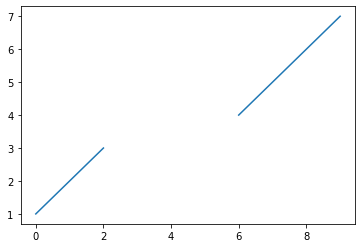

In [28]:

array = [1,2,3,float('nan'),float('nan'), float('nan'), 4,5,6,7]
plt.plot(array)